# Class-Conditional Synthesis with Latent Diffusion Models

## Install all the requirements and Imports


In [1]:
!kill -9 2782090 

/bin/bash: line 0: kill: (2782090) - No such process


In [2]:
with open("data/imagenette2/synset_human.txt", "r") as f:    
    synset_human = f.read().splitlines()
    synset_human = dict(line.split(maxsplit=1) for line in synset_human)


In [3]:
with open('data/synset_closest_idx.yaml', 'r') as file:
    synset_closest_idx = yaml.safe_load(file)

NameError: name 'yaml' is not defined

In [ ]:
synset_closest_idx

In [ ]:
import yaml 

with open('data/index_synset.yaml', 'r') as file:
    index_synset = yaml.safe_load(file)

# Accessing the data
print(index_synset)
synset_index = {v: k for k, v in index_synset.items()}

In [4]:
from nltk.corpus import wordnet as wn


In [5]:
def get_sim_synset(synset_id_1, synset_id_2):
    # Map the synset IDs to WordNet synsets
    synset_1 = wn.synset_from_pos_and_offset(synset_id_1[0], int(synset_id_1[1:]))
    synset_2 = wn.synset_from_pos_and_offset(synset_id_2[0], int(synset_id_2[1:]))

    # Calculate the Wu-Palmer Similarity score
    similarity_score = synset_1.wup_similarity(synset_2)
    return similarity_score

In [ ]:
import nltk

nltk.download('wordnet')


In [ ]:
nltk.download('omw-1.4')


In [ ]:
from collections import defaultdict

#get the closest two words for each synset
synset_closest_syn = defaultdict(list)
synset_closest_idx = defaultdict(list)
for k, v in index_synset.items():
    print(k, v)
    similarity_scores = []
    for k2, v2 in index_synset.items():
        #print(k, v, k2, v2)
        if k!=k2:
            similarity_scores.append((v2, get_sim_synset(v,v2)))

            
    # sort the similarity scores in ascending order
    similarity_scores.sort(key=lambda x: x[1], reverse=True)
    
    # add the closest two keys to the list for this synset
    closest_keys = [x[0] for x in similarity_scores[:2]]
    synset_closest_syn[v] = closest_keys
    synset_closest_idx[k] = [synset_index[x] for x in closest_keys]
    #break 


    

In [ ]:
#save synset_closest_syn and synset_closest_idx to yaml file
with open('data/synset_closest_syn.yaml', 'w') as file:

    documents = yaml.dump(dict(synset_closest_syn), file)

with open('data/synset_closest_idx.yaml', 'w') as file:
    documents = yaml.dump(dict(synset_closest_idx), file)
    

In [ ]:
synset_closest_idx, synset_closest_syn

In [ ]:
!nvidia-smi 

In [6]:
# import os
# import torch
# from torch import nn
# from torch import Tensor
# import pytorch_lightning as pl
# from omegaconf import OmegaConf
# from torch.nn import functional as F
# from torch.nn import Linear
# from torch.optim import AdamW
# from torch.optim.lr_scheduler import LambdaLR
# from copy import deepcopy
# from einops import rearrange
# from glob import glob
# from natsort import natsorted
# import kornia.augmentation as K
# import torchvision
# from torchvision.models import resnet18

# import torch
# from omegaconf import OmegaConf

# from ldm.util import instantiate_from_config

# from ldm.modules.diffusionmodules.openaimodel import EncoderUNetModel, UNetModel
# from ldm.util import log_txt_as_img, default, ismap, instantiate_from_config

# import numpy as np 
# from PIL import Image
# from einops import rearrange
# from torchvision.utils import make_grid

# import argparse, os, sys, glob
# import PIL
# import torch
# import numpy as np
# from omegaconf import OmegaConf
# from PIL import Image
# from tqdm import tqdm, trange
# from itertools import islice
# from einops import rearrange, repeat
# from torchvision.utils import make_grid
# from torch import autocast
# from contextlib import nullcontext
# import time
# from pytorch_lightning import seed_everything
# import matplotlib.pyplot as plt


# from src.clipseg.models.clipseg import CLIPDensePredT
# from PIL import Image
# from torchvision import transforms
# from matplotlib import pyplot as plt


# import numpy as np 
# from PIL import Image
# from einops import rearrange
# from torchvision.utils import make_grid

import argparse
import os
import time
from copy import deepcopy
from itertools import islice

import matplotlib.pyplot as plt
import numpy as np
import PIL
import imageio
from PIL import Image
from tqdm import tqdm, trange
from einops import rearrange, repeat

import torch
from torch import autocast
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import DataLoader

import pytorch_lightning as pl
from pytorch_lightning import seed_everything

from omegaconf import OmegaConf

import torchvision
from torchvision import transforms, datasets
from torchvision.utils import make_grid
import torchvision.transforms.functional as tf

import kornia.augmentation as K

from ldm.util import instantiate_from_config, log_txt_as_img, default, ismap
from ldm.modules.diffusionmodules.openaimodel import EncoderUNetModel, UNetModel
from src.clipseg.models.clipseg import CLIPDensePredT

In [7]:
device = "cuda:1" if torch.cuda.is_available() else "cpu"
!nvidia-smi

/misc/student/faridk/miniconda3/envs/ldm/lib/python3.8/site-packages/torch/cuda/__init__.py:82: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


Failed to initialize NVML: Driver/library version mismatch


In [8]:
%cd /misc/student/faridk/stable-diffusion

/misc/student/faridk/stable-diffusion


In [9]:
# #@title Installation

# !git clone https://github.com/CompVis/latent-diffusion.git
# !git clone https://github.com/CompVis/taming-transformers
# !pip install -e ./taming-transformers
# !pip install omegaconf>=2.0.0 pytorch-lightning>=1.0.8 torch-fidelity einops

import sys
sys.path.append(".")
sys.path.append('./taming-transformers')
from taming.models import vqgan 

In [10]:
from ldm import *

## Some Utils


In [11]:
#@title loading utils
def load_model_from_config(config, ckpt):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt)#, map_location="cpu")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    model.to(device) #.cuda()
    model.eval()
    return model


def get_model():
    config = OmegaConf.load("configs/latent-diffusion/cin256-v2.yaml")  
    model = load_model_from_config(config, "models/ldm/cin256-v2/model.ckpt")
    return model



def chunk(it, size):
    it = iter(it)
    return iter(lambda: tuple(islice(it, size)), ())


def load_img(path):
    image = Image.open(path).convert("RGB")
    w, h = image.size
    print(f"loaded input image of size ({w}, {h}) from {path}")
    w, h = map(lambda x: x - x % 32, (w, h))  # resize to integer multiple of 32
    image = image.resize((256, 256), resample=PIL.Image.LANCZOS)#((w, h), resample=PIL.Image.LANCZOS)
    pil_iamge = image
    image = np.array(image).astype(np.float32) / 255.0
    image = image[None].transpose(0, 3, 1, 2)
    image = torch.from_numpy(image)
    return image, pil_iamge


In [12]:
def generate_samples(model, sampler, classes, n_samples_per_class, ddim_steps, scale, init_image=None, t_enc=None, init_latent=None, ccdddim = False):

    all_samples = []
    
    with torch.no_grad():
        with model.ema_scope():
            tic = time.time()
            uc = model.get_learned_conditioning({model.cond_stage_key: torch.tensor(n_samples_per_class*[1000]).to(model.device)})

            for class_label in classes:
                print(f"rendering {n_samples_per_class} examples of class '{class_label}' in {ddim_steps} steps and using s={scale:.2f}.")
                xc = torch.tensor(n_samples_per_class*[class_label])
                c = model.get_learned_conditioning({model.cond_stage_key: xc.to(model.device)})
                if init_latent is not None:
                    y=xc.to(model.device)
                    z_enc = sampler.stochastic_encode(init_latent, torch.tensor([t_enc]*(n_samples_per_class)).to(device))
                    # decode it
                    if ccdddim:
                        samples = sampler.decode(z_enc, c, t_enc, unconditional_guidance_scale=scale, unconditional_conditioning=uc, y=xc.to(model.device))
                    else:
                        samples = sampler.decode(z_enc, c, t_enc, unconditional_guidance_scale=scale, unconditional_conditioning=uc)

                    x_samples = model.decode_first_stage(samples)
                    x_samples_ddim = torch.clamp((x_samples + 1.0) / 2.0, min=0.0, max=1.0)

                    cat_samples=torch.cat([init_image[:1], x_samples_ddim], dim=0)
                else:

                    samples_ddim, _ = sampler.sample(S=ddim_steps,
                                                    conditioning=c,
                                                    batch_size=n_samples_per_class,
                                                    shape=[3, 64, 64],
                                                    verbose=False,
                                                    unconditional_guidance_scale=scale,
                                                    unconditional_conditioning=uc, 
                                                    eta=ddim_eta)

                    x_samples_ddim = model.decode_first_stage(samples_ddim)
                    x_samples_ddim = torch.clamp((x_samples_ddim+1.0)/2.0, 
                                                min=0.0, max=1.0)
                    cat_samples=x_samples_ddim

                all_samples.append(cat_samples)


    
    return all_samples

## Prepare data

In [13]:
some_vces = {
    14655: [288, 292],
    10452: [207, 208],
    46751: [924, 959],
    48679: [970, 972],
    48539: [970, 980],
    48282: [963, 965]
}

data_path = '/misc/scratchSSD2/datasets/ILSVRC2012/val'
out_size = 256
transform_list = [
    transforms.Resize((out_size,out_size)),
    transforms.ToTensor()
]
transform = transforms.Compose(transform_list)

dataset = datasets.ImageFolder(data_path,  transform=transform)



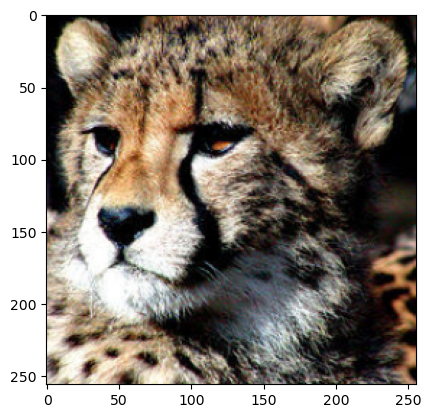

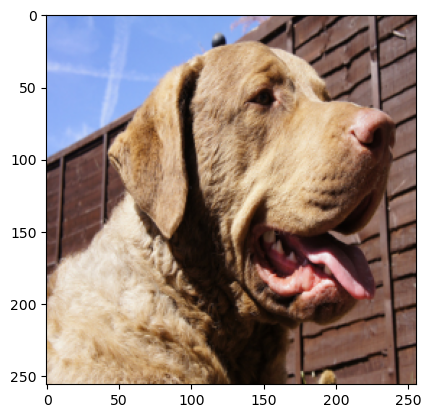

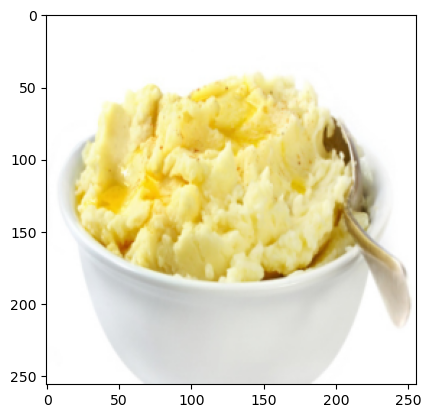

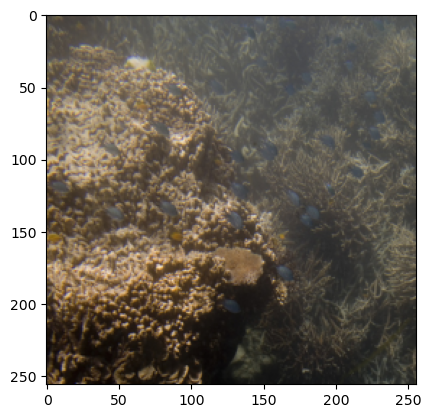

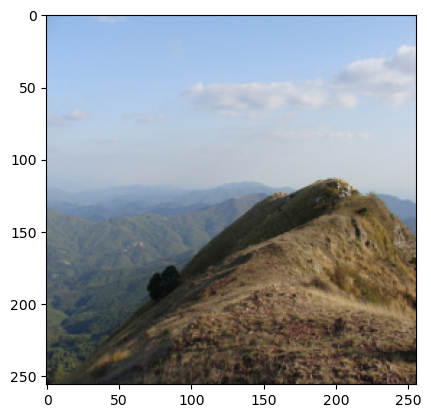

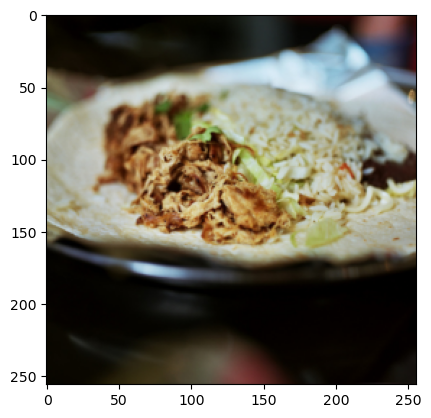

In [14]:
orig_vces = {}


images = []
for key in some_vces.keys():
    image = dataset[key][0].permute(1,2,0).cpu().numpy()
    images.append(dataset[key][0])
    orig_vces[key] = dataset[key][1]
    plt.imshow(image)
    plt.show()

images = torch.stack(images).to(device)

## Loading the models

In [15]:
# load model
model_seg = CLIPDensePredT(version='ViT-B/16', reduce_dim=16)
model_seg.eval();
model_seg.load_state_dict(torch.load('src/clipseg/weights/rd16-uni.pth', map_location=torch.device('cpu')), strict=False);


In [16]:
model = get_model()

Loading model from models/ldm/cin256-v2/model.ckpt
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 400.92 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels


In [17]:
from ldm.models.diffusion.ddim import DDIMSampler

sampler = DDIMSampler(model)

## Just sampling from the model 

And go. Quality, sampling speed and diversity are best controlled via the `scale`, `ddim_steps` and `ddim_eta` variables. As a rule of thumb, higher values of `scale` produce better samples at the cost of a reduced output diversity. Furthermore, increasing `ddim_steps` generally also gives higher quality samples, but returns are diminishing for values > 250. Fast sampling (i e. low values of `ddim_steps`) while retaining good quality can be achieved by using `ddim_eta = 0.0`.

In [ ]:
classes = [25, 187, 448, 992]   # define classes to be sampled here
n_samples_per_class = batch_size = 3

ddim_steps = 100
ddim_eta = 0.0
scale = 4.0   # for unconditional guidance


In [ ]:

all_samples =generate_samples(model, sampler, classes, n_samples_per_class, ddim_steps, scale)
# display as grid
grid = torch.stack(all_samples, 0)
grid = rearrange(grid, 'n b c h w -> (n b) c h w')
grid = make_grid(grid, nrow=n_samples_per_class)

# to image
grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
Image.fromarray(grid.astype(np.uint8))

## Creating counterfactual 



In [18]:
#"strength for noising/unnoising. 1.0 corresponds to full destruction of information in init image"
image_path = 'data/imagenette2/train/n03445777/ILSVRC2012_val_00002314.JPEG'
n_samples_per_class = batch_size = 3
strength = 0.46
ddim_steps = 250
ddim_eta = 0.0
scale = 4.0   # for unconditional guidance


loaded input image of size (500, 357) from data/imagenette2/train/n03445777/ILSVRC2012_val_00002314.JPEG


/tmp/ipykernel_3900477/2432764758.py:30: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  image = image.resize((256, 256), resample=PIL.Image.LANCZOS)#((w, h), resample=PIL.Image.LANCZOS)


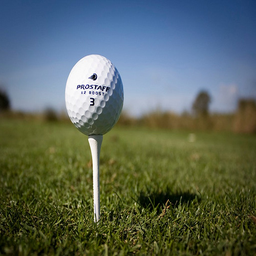

tensor(0.)


In [19]:
init_image, pil_image = load_img(image_path)
display(pil_image)
print(init_image.min())
init_image = init_image.to(device)
init_image = repeat(init_image, '1 ... -> b ...', b=n_samples_per_class)


### Getting the latent image coressponding to the original one 

In [ ]:
init_image.min()




In [ ]:
model.decode_first_stage(init_latent).min()




In [ ]:
mapped_image = 2.0 * init_image - 1.0
init_latent = model.get_first_stage_encoding(model.encode_first_stage(mapped_image))  # move to latent space
#put init latent on device
init_latent = init_latent.to(device)

plt.imshow(init_latent[0].permute(1, 2, 0).cpu().numpy())

### Getting the image close to the original one 

In [ ]:
n_samples_per_class = batch_size = 3
strength = 0.1
ddim_steps = 50
ddim_eta = 0.0
scale = 3.0   # for unconditional guidance
classes = [417, 852, 722]


In [ ]:
t_enc

In [ ]:
sampler.make_schedule(ddim_num_steps=ddim_steps, ddim_eta=ddim_eta, verbose=False)
assert 0. <= strength <= 1., 'can only work with strength in [0.0, 1.0]'
t_enc = int(strength * ddim_steps)
print(f"target t_enc is {t_enc} from ddim schedule {sampler.ddim_timesteps} steps.")
precision = "autocast" #"full"
precision_scope = autocast if precision == "autocast" else nullcontext

In [ ]:
sampler.ddim_alphas.device

In [ ]:
all_samples =generate_samples(model, sampler, classes, n_samples_per_class, ddim_steps, scale, init_latent=init_latent, t_enc=t_enc, init_image=init_image)

In [ ]:
# display as grid
grid = torch.stack(all_samples, 0)
grid = rearrange(grid, 'n b c h w -> (n b) c h w')
grid = make_grid(grid, nrow=n_samples_per_class+1)

# to image
grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
Image.fromarray(grid.astype(np.uint8))

### Trying with different settings

In [ ]:
n_samples_per_class = batch_size = 3
strength = 0.46
ddim_steps = 200
ddim_eta = 0.0
scale = 3.0   # for unconditional guidance


In [ ]:
sampler.make_schedule(ddim_num_steps=ddim_steps, ddim_eta=ddim_eta, verbose=False)
assert 0. <= strength <= 1., 'can only work with strength in [0.0, 1.0]'
t_enc = int(strength * ddim_steps)
print(f"target t_enc is {t_enc} from ddim schedule {sampler.ddim_timesteps} steps.")
precision = "autocast" #"full"
precision_scope = autocast if precision == "autocast" else nullcontext

In [ ]:
classes = [417, 852, 722]

In [ ]:
all_samples = generate_samples(model, sampler, classes, n_samples_per_class, ddim_steps, scale, init_image, t_enc, init_latent)
# display as grid
grid = torch.stack(all_samples, 0)
grid = rearrange(grid, 'n b c h w -> (n b) c h w')
grid = make_grid(grid, nrow=n_samples_per_class+1)

# to image
grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
Image.fromarray(grid.astype(np.uint8))

## Now trying CLIPseg


In [ ]:
#"strength for noising/unnoising. 1.0 corresponds to full destruction of information in init image"
image_path = 'data/imagenette2/train/n03445777/ILSVRC2012_val_00002314.JPEG'
n_samples_per_class = batch_size = 3
strength = 0.46
ddim_steps = 250
ddim_eta = 0.0
scale = 4.0   # for unconditional guidance

init_image, pil_image = load_img(image_path)
display(pil_image)
print(init_image.min())
init_image = init_image.to(device)
init_image = repeat(init_image, '1 ... -> b ...', b=n_samples_per_class)


In [ ]:
mean, std =[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
transform = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Resize((352, 352)),
])

img = transform(init_image[0].unsqueeze(0))
print(img.max(), img.min(), img[0].mean(axis=(1,2)))

plt.imshow(img[0].permute(1, 2, 0).cpu().numpy())

In [ ]:
images.shape

In [ ]:
preds.size()

In [ ]:

prompts = ['the focus is on', 'a golf ball', 'on a stick', 'on grass', 'under a blue sky']

# predict
with torch.no_grad():
    preds = model_seg(img.repeat(5,1,1,1), prompts)[0]

# visualize prediction
_, ax = plt.subplots(1, 6, figsize=(15, 6))
[a.axis('off') for a in ax.flatten()]
# denormalize image
img_orig = img[0].permute(1, 2, 0).cpu().numpy()
img_orig = img_orig * np.array(std)[None, None, :] + np.array(mean)[None, None, :] 
ax[0].imshow(img_orig)
preds = torch.sigmoid(preds)
#normalize preds using softmax
preds = torch.softmax(preds.view(5, -1), dim=1).view(5, 1, 352, 352)
[ax[i+1].imshow(preds[i][0]) for i in range(5)];
[ax[i+1].text(0, -15, prompts[i]) for i in range(5)];

In [ ]:
preds.shape

In [ ]:

prompts = []
for l in orig_vces.values():
    prompts.append(re.sub(r'\b(\w)', lambda m: m.group(1).upper(), i2h[l]))
with torch.no_grad():
    img_to_seg=F.interpolate(normalize(images), size=(352, 352), mode='bilinear', align_corners=False).to(device)
    preds = model_seg(img_to_seg, prompts)[0]
    preds = F.interpolate(preds, size=images.shape[-2:], mode='bilinear', align_corners=False).cpu()
    preds = torch.sigmoid(preds) #torch.softmax(preds.view(preds.shape[0], -1), dim=1).view(*preds.shape)
_, ax = plt.subplots(3, 6, figsize=(15, 6))
[a.axis('off') for a in ax.flatten()]
# denormalize image
[ax[0, i].imshow(images[i].permute(1, 2, 0).cpu().numpy()) for i in range(6)];

[ax[1, i].imshow(1-preds[i][0]) for i in range(6)];
[ax[2, i].imshow(preds[i][0]) for i in range(6)];
[ax[2, i].text(0, -15, prompts[i]) for i in range(6)];



In [ ]:
preds.mean()

## Sampling from the counterfactual sampler

In [20]:
"""SAMPLING ONLY."""

import torch
import time
import numpy as np
from tqdm import tqdm
from torch.nn import functional as F
from torch import distributions as torchd
from functools import partial

from ldm.modules.diffusionmodules.util import make_ddim_sampling_parameters, make_ddim_timesteps, noise_like, \
    extract_into_tensor

### Some utilities 

In [21]:
import regex as re
classes = [417, 852] #, 722]

In [22]:
#load txt file with mapping from 'data/imagenet_clsidx_to_label.txt'
#to get the class names
i2h = dict()
with open('data/imagenet_clsidx_to_label.txt', "r") as f:
        lines = f.read().splitlines()
        assert len(lines) == 1000

        for line in lines:
            key, value = line.split(":")
            i2h[int(key)] = re.sub(r"^'|',?$", "", value.strip()) #value.strip().strip("'").strip(",").strip("\"")



In [23]:
def compute_lp_dist(diff, p):
    diff_abs_flat = diff.abs().view(diff.shape[0], -1)
    if p == 1.0:
        lp_dist = torch.sum(diff_abs_flat, dim=1)
    else:
        lp_dist = torch.sum(diff_abs_flat ** p, dim=1)
    return lp_dist


def compute_lp_gradient(diff, p, small_const=1e-12):
    if p < 1:
        grad_temp = (p * (diff.abs() + small_const) ** (

                p - 1)) * diff.sign()
    else:
        grad_temp = (p * diff.abs() ** (p - 1)) * diff.sign()
    return grad_temp


def _renormalize_gradient(grad, eps, small_const=1e-22):

    grad_norm = grad.view(grad.shape[0], -1).norm(p=2, dim=1).view(grad.shape[0], 1, 1, 1)
    grad_norm = torch.where(grad_norm < small_const, grad_norm + small_const, grad_norm)
    grad /= grad_norm
    grad *= eps.view(grad.shape[0], -1).norm(p=2, dim=1).view(grad.shape[0], 1, 1, 1)
    return grad, grad_norm

def renormalize(a, b, small_const=1e-22):
    #changes(removed detach and restored where)
    a_norm = a.view(a.shape[0], -1).norm(p=2, dim=1).view(b.shape[0], 1, 1, 1)
    a_norm_new = torch.where(a_norm < small_const, a_norm + small_const, a_norm) #torch.clamp(a_norm, min=small_const) #.detach() #torch.where(a_norm < small_const, a_norm + small_const, a_norm)
    a /= a_norm_new
    a *= b.view(a.shape[0], -1).norm(p=2, dim=1).view(a.shape[0], 1, 1, 1)
    return a, a_norm_new



class OneHotDist(torchd.one_hot_categorical.OneHotCategorical):

    def __init__(self, logits=None, probs=None):
        super().__init__(logits=logits, probs=probs)

    def mode(self):
        _mode = F.one_hot(torch.argmax(super().logits, axis=-1), super().logits.shape[-1])
        return _mode.detach() + super().logits - super().logits.detach()

    def sample(self, sample_shape=(), seed=None):
        if seed is not None:
            raise ValueError('need to check')
        sample = super().sample(sample_shape)
        probs = super().probs
        while len(probs.shape) < len(sample.shape):
            probs = probs[None]
        sample += probs - probs.detach()
        return sample


def cone_project(grad_temp_1, grad_temp_2, deg):
    """
    grad_temp_1: gradient of the loss w.r.t. the robust/classifier free
    grad_temp_2: gradient of the loss w.r.t. the non-robust
    projecting the robust/CF onto the non-robust 
    """
    angles_before = torch.acos(
        (grad_temp_1 * grad_temp_2).sum(1) / (grad_temp_1.norm(p=2, dim=1) * grad_temp_2.norm(p=2, dim=1)))
    ##print('angle before', angles_before)
    grad_temp_2 /= grad_temp_2.norm(p=2, dim=1).view(grad_temp_1.shape[0], -1)
    grad_temp_1 = grad_temp_1 - ((grad_temp_1 * grad_temp_2).sum(1) / (grad_temp_2.norm(p=2, dim=1) ** 2)).view(
        grad_temp_1.shape[0], -1) * grad_temp_2
    grad_temp_1 /= grad_temp_1.norm(p=2, dim=1).view(grad_temp_1.shape[0], -1)
    # cone_projection = grad_temp_1 + grad_temp_2 45 deg
    radians = torch.tensor([deg], device=grad_temp_1.device).deg2rad()
    ##print('angle after', radians, torch.acos((grad_temp_1*grad_temp_2).sum(1) / (grad_temp_1.norm(p=2,dim=1) * grad_temp_2.norm(p=2,dim=1))))
    cone_projection = grad_temp_1 * torch.tan(radians) + grad_temp_2

    # second classifier is a non-robust one -
    # unless we are less than 45 degrees away - don't cone project
    grad_temp = grad_temp_2.clone()
    loop_projecting = time.time()
    grad_temp[angles_before > radians] = cone_projection[angles_before > radians]

    return grad_temp

def normalize(x):
    mean, std =[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
    x = x - torch.tensor(mean).to(x.device)[None, :, None, None]
    x = x / torch.tensor(std).to(x.device)[None, :, None, None]
    return x

def denormalize(x):
    mean, std =[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
    x = x * torch.tensor(std).to(x.device)[None, :, None, None]
    x = x + torch.tensor(mean).to(x.device)[None, :, None, None]
    return x


def _map_img(x):
    #from -1 to 1 to 0 to 1 
    return 0.5 * (x + 1)

def _unmap_img(x, from_image_net_dist = False):
    #from 0 to 1 to -1 to 1

    return 2. * x -1

def disabled_train(self, mode=True):
    """Overwrite model.train with this function to make sure train/eval mode
    does not change anymore."""
    return self


### Defining the new ddim 

In [27]:
class CCDDIMSampler(object):
    def __init__(self, model, classifier, model_type="latent", schedule="linear", guidance="free", lp_custom=False,
                 deg_cone_projection=10, denoise_dist_input=True, classifier_lambda=1, dist_lambda=0.15,
                 enforce_same_norms=True, seg_model = None, masked_guidance = False, masked_dist = False, **kwargs):

        super().__init__()
        self.model_type = model_type
        self.lp_custom = lp_custom
        self.images = []
        self.probs = []
        self.classifier_lambda = classifier_lambda
        self.model = model
        self.ddpm_num_timesteps = model.num_timesteps
        self.schedule = schedule
        self.classifier = classifier
        self.guidance = guidance
        # self.projected_counterfactuals = projected_counterfactuals
        self.deg_cone_projection = deg_cone_projection
        self.denoise_dist_input = denoise_dist_input
        self.dist_lambda = dist_lambda
        self.enforce_same_norms = enforce_same_norms
        self.seg_model = seg_model
        self.masked_dist = masked_dist
        self.masked_guidance = masked_guidance

        self.init_images = None
        self.init_labels = None

    def get_classifier_dist(self, x, t=None):
        """
        Create a distribution over the classifier output space
        Args:
            x: input image for which to create the distribution over the classifier output space range [-1, 1]

        Returns:
            dist: torch distribution over the classifier output space

        """
        # convert x to range [0,1]
        # x = _map_img(x)
        # resize x to the classifier input size
        # x = F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
        # SHOW IMAGE


        x = tf.center_crop(x, 224)
        x = normalize(_map_img(x))
        logit = self.classifier(x)  # (TODO) add option for t here
        dist = torchd.independent.Independent(OneHotDist(logit), 1)
        return dist


    def get_mask(self):
        """
        this function returns a negative mask given by a segmentation model for the region of interest
        values are higher outside the region of interest
        """
        prompts = []
        for l in self.init_labels:
            prompts.append(re.sub(r'\b(\w)', lambda m: m.group(1).upper(), i2h[l]))
        
        with torch.no_grad():
            img_to_seg=F.interpolate(normalize(self.init_images), size=(352, 352), mode='bilinear', align_corners=False).to(device)
            preds = self.seg_model(img_to_seg, prompts)[0]
            preds = F.interpolate(preds, size=self.init_images.shape[-2:], mode='bilinear', align_corners=False)
            preds = torch.sigmoid(preds) #torch.softmax(preds.view(preds.shape[0], -1), dim=1).view(*preds.shape)
            #penalty = 1-preds
        
        return preds.to(device)
        
    def get_output(self, x, t, c, index, unconditional_conditioning, use_original_steps=True, quantize_denoised=True, return_decoded=False):
        b = x.shape[0]
        x_in = torch.cat([x] * 2)
        t_in = torch.cat([t] * 2)
        c_in = torch.cat([unconditional_conditioning, c])
        #with torch.no_grad():
        e_t_uncond, e_t = self.model.apply_model(x_in, t_in, c_in).chunk(2)
            
        if return_decoded:
            # getting the original denoised image
            alphas = self.model.alphas_cumprod if use_original_steps else self.ddim_alphas
            sqrt_one_minus_alphas = self.model.sqrt_one_minus_alphas_cumprod if use_original_steps else self.ddim_sqrt_one_minus_alphas
            a_t = torch.full((b, 1, 1, 1), alphas[index], device=device)
            sqrt_one_minus_at = torch.full((b, 1, 1, 1), sqrt_one_minus_alphas[index], device=device)
            # current prediction for x_0
            # get the original image with range [0, 1] if it is in latent space
            pred_latent_x0 = (x - sqrt_one_minus_at * e_t_uncond) / a_t.sqrt() # e_t - >  e_t_uncond
            if quantize_denoised:
                pred_latent_x0, _, *_ = self.model.first_stage_model.quantize(pred_latent_x0)

            
            pred_x0 = self.model.differentiable_decode_first_stage(
                pred_latent_x0)  # if self.model_type == "latent" else pred_latent_x0
            #pred_x0 = torch.clamp((pred_x0 + 1.0) / 2.0, min=0.0, max=1.0)
            return e_t_uncond, e_t, pred_x0
        
        else:
            return e_t_uncond, e_t

    def conditional_score(self, x, t, c, index, use_original_steps, quantize_denoised, unconditional_guidance_scale=1.,
                          unconditional_conditioning=None, y=None):
        """

        Args:
            x: input image
            t: time step
            c: conditioning
            index: index for the schedule
            use_original_steps: whether to use the original steps
            quantize_denoised: whether to quantize the denoised image
            unconditional_guidance_scale: scale for the unconditional guidance
            unconditional_conditioning: unconditional conditioning
            y: target class


        Returns:
            e_t: score after conditioning

        """
        b, *_, device = *x.shape, x.device
        x = x.detach()#.requires_grad_()
        #x.requires_grad = True
        prob_best_class = None
        mask_guidance  = None
        mask_dist = None
        ## check if gradient tracking is on for x
        
        if self.masked_guidance or self.masked_dist:
            mask = self.get_mask()

            if self.masked_guidance: 
                mask_guidance = F.interpolate(mask, size=x.shape[-2:], mode='bilinear', align_corners=False)
            
            if self.masked_dist:
                mask_dist = F.interpolate(1 - mask, size=x.shape[-2:], mode='bilinear', align_corners=False)#1 - mask

        if unconditional_conditioning is None or unconditional_guidance_scale == 1.:
            e_t = self.model.apply_model(x, t, c)
            return e_t

        
        #print("check gradient tracking onf e ", e_t.requires_grad)
        if self.guidance == "free":
            e_t_uncond, e_t, pred_x0 = self.get_output(x, t, c, index, unconditional_conditioning, use_original_steps, quantize_denoised, return_decoded=True)

            if self.masked_guidance:
                e_t = e_t_uncond +  unconditional_guidance_scale * renormalize(mask_guidance * (e_t - e_t_uncond), e_t - e_t_uncond)[0] #mask_guidance * (e_t - e_t_uncond)
            else:
                e_t = e_t_uncond + unconditional_guidance_scale * (e_t - e_t_uncond)
            
            return e_t

        #print("check gradient tracking onf e ", e_t.requires_grad)
        score_out = torch.zeros_like(x)
        
        with torch.enable_grad():
            assert x.requires_grad == False, "x requires grad"
            
            if self.classifier_lambda != 0:
                x_grad = x.detach().requires_grad_()
                e_t_uncond, e_t, pred_x0 = self.get_output(x_grad, t, c, index, unconditional_conditioning, use_original_steps, quantize_denoised=quantize_denoised, return_decoded=True)
                classifier_dist = self.get_classifier_dist(pred_x0)
                y_one_hot = F.one_hot(y, classifier_dist.event_shape[-1]).to(device)
                log_probs = classifier_dist.log_prob(y_one_hot)
                prob_best_class = torch.exp(log_probs)
                print("prob_best_class", prob_best_class)

                grad_classifier = torch.autograd.grad(log_probs.sum(), x_grad)[
                    0]
        with torch.enable_grad():  
            if self.lp_custom:
                assert x.requires_grad == False, "x requires grad"
                x_grad = x.detach().requires_grad_()
                e_t_uncond, e_t, pred_x0 = self.get_output(x_grad, t, c, index, unconditional_conditioning, use_original_steps, quantize_denoised=quantize_denoised, return_decoded=True)
                #print("computing the lp gradient")
                assert pred_x0.requires_grad == True, "pred_x0 does not require grad"
                pred_x0_0to1 = torch.clamp(_map_img(pred_x0), min=0.0, max=1.0)
                diff =  pred_x0_0to1 - self.init_images.to(device)
                #print("diff is:", diff.mean())
                lp_dist = compute_lp_dist(diff, self.lp_custom)
                lp_grad = torch.autograd.grad(lp_dist.mean(), x_grad)[0]

        #assert e_t_uncond.requires_grad == True and e_t.requires_grad == True, "e_t_uncond and e_t should require gradients"
        

        if self.guidance == "projected":
            implicit_classifier_score = (e_t - e_t_uncond)#.detach()
            # check gradient tracking on implicit_classifier_score 
            assert implicit_classifier_score.requires_grad == False, "implicit_classifier_score requires grad"

        if self.lp_custom or self.classifier_lambda != 0:
            alphas = self.model.alphas_cumprod if use_original_steps else self.ddim_alphas
            a_t = torch.full((b, 1, 1, 1), alphas[index], device=device)
            
        if self.classifier_lambda != 0:

            classifier_score = -1  * grad_classifier * (1 - a_t).sqrt()
            assert classifier_score.requires_grad == False, "classifier_score requires grad"
            classifier_score = renormalize(classifier_score * mask_guidance, classifier_score)[0] if self.masked_guidance else classifier_score
            implicit_classifier_score = renormalize(implicit_classifier_score * mask_guidance, implicit_classifier_score)[0] if self.masked_guidance else implicit_classifier_score
            # project the gradient of the classifier on the implicit classifier
            classifier_score = cone_project(implicit_classifier_score.view(x.shape[0], -1),
                                            classifier_score.view(x.shape[0], -1),
                                            self.deg_cone_projection).view_as(classifier_score) \
                if self.guidance == "projected" else classifier_score

            if self.enforce_same_norms:
                score_, norm_ = _renormalize_gradient(classifier_score, implicit_classifier_score)  # e_t_uncond (AWAREE!!) 
                classifier_score = self.classifier_lambda * score_
                
            else:
                classifier_score *= self.classifier_lambda

            #print("classifier score is", classifier_score.mean(), "classifier norm is", classifier_score.view(classifier_score.shape[0], -1).norm(p=2, dim=1).mean())
            score_out += classifier_score

        # distance gradients
        if self.lp_custom:
            
            lp_score = -1 * lp_grad * (1 - a_t).sqrt()
            lp_score = mask_dist * lp_score if self.masked_dist else lp_score
            
            if self.enforce_same_norms:
                
                score_, norm_ = _renormalize_gradient(lp_score, implicit_classifier_score) # e_t_uncond if self.classifier_lambda == 0 else implicit_classifier_score) #.detach()) #, implicit_classifier_score) (AWAREE!!)
                lp_score = self.dist_lambda * score_
                #print("score is:", lp_score, lp_score.mean())
                

            else:
                
                lp_score *= self.dist_lambda
                
            score_out -= lp_score

        e_t = e_t_uncond + unconditional_guidance_scale * score_out  # (1 - a_t).sqrt() * grad_out

        #adding images to create a gif
       # print("adding images to create a gif")
        pred_x0_copy = pred_x0.clone().detach()
        #print("pred_x0_copy.shape ", pred_x0_copy.shape)
        img = torch.clamp(_map_img(pred_x0_copy), min=0.0, max=1.0)
        img_np = img.permute(0, 2, 3, 1).cpu().detach().numpy()
        img_np = np.hstack((*img_np,))
        img_np = (img_np * 255).astype(np.uint8)
        
        
        self.images.append(img_np)
        if prob_best_class is not None:
            self.probs.append(prob_best_class)
        
        return e_t

    def register_buffer(self, name, attr):
        if type(attr) == torch.Tensor:
            pass
            # TODO: this is a hack to make it work on CPU
            if attr.device != torch.device("cuda"):
                attr = attr.to(torch.device("cuda"))
        setattr(self, name, attr)

    def make_schedule(self, ddim_num_steps, ddim_discretize="uniform", ddim_eta=0., verbose=True):
        self.ddim_timesteps = make_ddim_timesteps(ddim_discr_method=ddim_discretize, num_ddim_timesteps=ddim_num_steps,
                                                  num_ddpm_timesteps=self.ddpm_num_timesteps, verbose=verbose)
        alphas_cumprod = self.model.alphas_cumprod
        assert alphas_cumprod.shape[0] == self.ddpm_num_timesteps, 'alphas have to be defined for each timestep'
        to_torch = lambda x: x.clone().detach().to(torch.float32).to(self.model.device)

        self.register_buffer('betas', to_torch(self.model.betas))
        self.register_buffer('alphas_cumprod', to_torch(alphas_cumprod))
        self.register_buffer('alphas_cumprod_prev', to_torch(self.model.alphas_cumprod_prev))

        # calculations for diffusion q(x_t | x_{t-1}) and others
        self.register_buffer('sqrt_alphas_cumprod', to_torch(np.sqrt(alphas_cumprod.cpu())))
        self.register_buffer('sqrt_one_minus_alphas_cumprod', to_torch(np.sqrt(1. - alphas_cumprod.cpu())))
        self.register_buffer('log_one_minus_alphas_cumprod', to_torch(np.log(1. - alphas_cumprod.cpu())))
        self.register_buffer('sqrt_recip_alphas_cumprod', to_torch(np.sqrt(1. / alphas_cumprod.cpu())))
        self.register_buffer('sqrt_recipm1_alphas_cumprod', to_torch(np.sqrt(1. / alphas_cumprod.cpu() - 1)))

        # ddim sampling parameters
        ddim_sigmas, ddim_alphas, ddim_alphas_prev = make_ddim_sampling_parameters(alphacums=alphas_cumprod.cpu(),
                                                                                   ddim_timesteps=self.ddim_timesteps,
                                                                                   eta=ddim_eta, verbose=verbose)
        self.register_buffer('ddim_sigmas', ddim_sigmas)
        self.register_buffer('ddim_alphas', ddim_alphas)
        self.register_buffer('ddim_alphas_prev', ddim_alphas_prev)
        self.register_buffer('ddim_sqrt_one_minus_alphas', np.sqrt(1. - ddim_alphas))
        sigmas_for_original_sampling_steps = ddim_eta * torch.sqrt(
            (1 - self.alphas_cumprod_prev) / (1 - self.alphas_cumprod) * (
                    1 - self.alphas_cumprod / self.alphas_cumprod_prev))
        self.register_buffer('ddim_sigmas_for_original_num_steps', sigmas_for_original_sampling_steps)

    @torch.no_grad()
    def sample(self,
               S,
               batch_size,
               shape,
               conditioning=None,
               callback=None,
               normals_sequence=None,
               img_callback=None,
               quantize_x0=False,
               eta=0.,
               mask=None,
               x0=None,
               temperature=1.,
               noise_dropout=0.,
               score_corrector=None,
               corrector_kwargs=None,
               verbose=True,
               x_T=None,
               log_every_t=100,
               unconditional_guidance_scale=1.,
               unconditional_conditioning=None,
               # this has to come in the same format as the conditioning, # e.g. as encoded tokens, ...
               **kwargs
               ):
        if conditioning is not None:
            if isinstance(conditioning, dict):
                cbs = conditioning[list(conditioning.keys())[0]].shape[0]
                if cbs != batch_size:
                    print(f"Warning: Got {cbs} conditionings but batch-size is {batch_size}")
            else:
                if conditioning.shape[0] != batch_size:
                    print(f"Warning: Got {conditioning.shape[0]} conditionings but batch-size is {batch_size}")

        self.make_schedule(ddim_num_steps=S, ddim_eta=eta, verbose=verbose)
        # sampling
        C, H, W = shape
        size = (batch_size, C, H, W)
        print(f'Data shape for DDIM sampling is {size}, eta {eta}')

        samples, intermediates = self.ddim_sampling(conditioning, size,
                                                    callback=callback,
                                                    img_callback=img_callback,
                                                    quantize_denoised=quantize_x0,
                                                    mask=mask, x0=x0,
                                                    ddim_use_original_steps=False,
                                                    noise_dropout=noise_dropout,
                                                    temperature=temperature,
                                                    score_corrector=score_corrector,
                                                    corrector_kwargs=corrector_kwargs,
                                                    x_T=x_T,
                                                    log_every_t=log_every_t,
                                                    unconditional_guidance_scale=unconditional_guidance_scale,
                                                    unconditional_conditioning=unconditional_conditioning,
                                                    )
        return samples, intermediates

    @torch.no_grad()
    def ddim_sampling(self, cond, shape,
                      x_T=None, ddim_use_original_steps=False,
                      callback=None, timesteps=None, quantize_denoised=False,
                      mask=None, x0=None, img_callback=None, log_every_t=100,
                      temperature=1., noise_dropout=0., score_corrector=None, corrector_kwargs=None,
                      unconditional_guidance_scale=1., unconditional_conditioning=None, ):

        device = self.model.betas.device
        b = shape[0]
        if x_T is None:
            img = torch.randn(shape, device=device)
        else:
            img = x_T

        if timesteps is None:
            timesteps = self.ddpm_num_timesteps if ddim_use_original_steps else self.ddim_timesteps
        elif timesteps is not None and not ddim_use_original_steps:
            subset_end = int(min(timesteps / self.ddim_timesteps.shape[0], 1) * self.ddim_timesteps.shape[0]) - 1
            timesteps = self.ddim_timesteps[:subset_end]

        intermediates = {'x_inter': [img], 'pred_x0': [img]}
        time_range = reversed(range(0, timesteps)) if ddim_use_original_steps else np.flip(timesteps)
        total_steps = timesteps if ddim_use_original_steps else timesteps.shape[0]
        print(f"Running DDIM Sampling with {total_steps} timesteps")

        iterator = tqdm(time_range, desc='DDIM Sampler', total=total_steps)

        for i, step in enumerate(iterator):
            index = total_steps - i - 1
            ts = torch.full((b,), step, device=device, dtype=torch.long)

            if mask is not None:
                assert x0 is not None
                img_orig = self.model.q_sample(x0, ts)  # TODO: deterministic forward pass?
                img = img_orig * mask + (1. - mask) * img

            outs = self.p_sample_ddim(img, cond, ts, index=index, use_original_steps=ddim_use_original_steps,
                                      quantize_denoised=quantize_denoised, temperature=temperature,
                                      noise_dropout=noise_dropout, score_corrector=score_corrector,
                                      corrector_kwargs=corrector_kwargs,
                                      unconditional_guidance_scale=unconditional_guidance_scale,
                                      unconditional_conditioning=unconditional_conditioning)
            img, pred_x0 = outs
            if callback: callback(i)
            if img_callback: img_callback(pred_x0, i)

            if index % log_every_t == 0 or index == total_steps - 1:
                intermediates['x_inter'].append(img)
                intermediates['pred_x0'].append(pred_x0)

        return img, intermediates

    @torch.no_grad()
    def p_sample_ddim(self, x, c, t, index, repeat_noise=False, use_original_steps=False, quantize_denoised=False,
                      temperature=1., noise_dropout=0., score_corrector=None, corrector_kwargs=None,
                      unconditional_guidance_scale=1., unconditional_conditioning=None, y=None):
        b, *_, device = *x.shape, x.device

        e_t = self.conditional_score(x=x, c=c, t=t, index=index, use_original_steps=use_original_steps,
                                     quantize_denoised=quantize_denoised,
                                     unconditional_guidance_scale=unconditional_guidance_scale,
                                     unconditional_conditioning=unconditional_conditioning, y=y)

        if score_corrector is not None:
            assert self.model.parameterization == "eps"
            e_t = score_corrector.modify_score(self.model, e_t, x, t, c, **corrector_kwargs)

        alphas = self.model.alphas_cumprod if use_original_steps else self.ddim_alphas
        alphas_prev = self.model.alphas_cumprod_prev if use_original_steps else self.ddim_alphas_prev
        sqrt_one_minus_alphas = self.model.sqrt_one_minus_alphas_cumprod if use_original_steps else self.ddim_sqrt_one_minus_alphas
        sigmas = self.model.ddim_sigmas_for_original_num_steps if use_original_steps else self.ddim_sigmas
        # select parameters corresponding to the currently considered timestep
        a_t = torch.full((b, 1, 1, 1), alphas[index], device=device)
        a_prev = torch.full((b, 1, 1, 1), alphas_prev[index], device=device)
        sigma_t = torch.full((b, 1, 1, 1), sigmas[index], device=device)
        sqrt_one_minus_at = torch.full((b, 1, 1, 1), sqrt_one_minus_alphas[index], device=device)

        # current prediction for x_0
        pred_x0 = (x - sqrt_one_minus_at * e_t) / a_t.sqrt()
        if quantize_denoised:
            pred_x0, _, *_ = self.model.first_stage_model.quantize(pred_x0)
        # direction pointing to x_t
        dir_xt = (1. - a_prev - sigma_t ** 2).sqrt() * e_t
        noise = sigma_t * noise_like(x.shape, device, repeat_noise) * temperature
        if noise_dropout > 0.:
            noise = torch.nn.functional.dropout(noise, p=noise_dropout)
        x_prev = a_prev.sqrt() * pred_x0 + dir_xt + noise
        return x_prev, pred_x0

    @torch.no_grad()
    def stochastic_encode(self, x0, t, use_original_steps=False, noise=None):
        # fast, but does not allow for exact reconstruction
        # t serves as an index to gather the correct alphas
        if use_original_steps:
            sqrt_alphas_cumprod = self.sqrt_alphas_cumprod
            sqrt_one_minus_alphas_cumprod = self.sqrt_one_minus_alphas_cumprod
        else:
            sqrt_alphas_cumprod = torch.sqrt(self.ddim_alphas).to(x0.device)
            sqrt_one_minus_alphas_cumprod = self.ddim_sqrt_one_minus_alphas.to(x0.device)

        if noise is None:
            noise = torch.randn_like(x0)
        return (extract_into_tensor(sqrt_alphas_cumprod, t, x0.shape) * x0 +
                extract_into_tensor(sqrt_one_minus_alphas_cumprod, t, x0.shape) * noise)

    @torch.no_grad()
    def decode(self, x_latent, cond, t_start, y=None, unconditional_guidance_scale=1.0, unconditional_conditioning=None,
               use_original_steps=False):

        timesteps = np.arange(self.ddpm_num_timesteps) if use_original_steps else self.ddim_timesteps
        timesteps = timesteps[:t_start]

        time_range = np.flip(timesteps)
        total_steps = timesteps.shape[0]
        print(f"Running DDIM Sampling with {total_steps} timesteps")

        iterator = tqdm(time_range, desc='Decoding image', total=total_steps)
        x_dec = x_latent
        for i, step in enumerate(iterator):
            index = total_steps - i - 1
            ts = torch.full((x_latent.shape[0],), step, device=x_latent.device, dtype=torch.long)
            x_dec, _ = self.p_sample_ddim(x_dec, cond, ts, index=index, use_original_steps=use_original_steps,
                                          unconditional_guidance_scale=unconditional_guidance_scale,
                                          unconditional_conditioning=unconditional_conditioning, y=y)

        if len(self.images) != 0:
            #create a gif of the images
            if len(self.probs) == 0:
                viewimg_path = f"generation_process_{y[0]}_cc_{self.classifier_lambda}_cd_{self.dist_lambda}_ts_{t_start}_tts_{timesteps[-1]}_{len(timesteps)}_conf_{self.probs[-1]}.mp4"
            else:
                viewimg_path = f"generation_process_{y[0]}_cc_{self.classifier_lambda}_cd_{self.dist_lambda}_ts_{t_start}_tts_{timesteps[-1]}_{len(timesteps)}.mp4"

            imageio.mimwrite(viewimg_path, self.images)
            print(f"Saved gif of generation process to {viewimg_path}")
        self.images = []
        self.probs = []
        return x_dec


In [28]:


#     def conditional_score(self, x, t, c, index, use_original_steps, quantize_denoised, unconditional_guidance_scale=1.,
#                           unconditional_conditioning=None, y=None):
#         """

#         Args:
#             x: input image
#             t: time step
#             c: conditioning
#             index: index for the schedule
#             use_original_steps: whether to use the original steps
#             quantize_denoised: whether to quantize the denoised image
#             unconditional_guidance_scale: scale for the unconditional guidance
#             unconditional_conditioning: unconditional conditioning
#             y: target class


#         Returns:
#             e_t: score after conditioning

#         """
#         b, *_, device = *x.shape, x.device
#         x = x.detach().requires_grad_()
#         #x.requires_grad = True

#         mask_guidance  = None
#         mask_dist = None
#         ## check if gradient tracking is on for x
#         if not x.requires_grad:
#             raise ValueError("x does not require gradients")
#         if self.masked_guidance or self.masked_dist:
#             mask = self.get_mask()

#             if self.masked_guidance: 
#                 mask_guidance = F.interpolate(mask, size=x.shape[-2:], mode='bilinear', align_corners=False)
            
#             if self.masked_dist:
#                 mask_dist = F.interpolate(1 - mask, size=x.shape[-2:], mode='bilinear', align_corners=False)#1 - mask

#         if unconditional_conditioning is None or unconditional_guidance_scale == 1.:
#             e_t = self.model.apply_model(x, t, c)
#             return e_t

#         else:
#             with torch.enable_grad():

#                 x_in = torch.cat([x] * 2)
#                 t_in = torch.cat([t] * 2)
#                 c_in = torch.cat([unconditional_conditioning, c])
#                 e_t_uncond, e_t = self.model.apply_model(x_in, t_in, c_in).chunk(2)
        
#         assert e_t_uncond.requires_grad == True and e_t.requires_grad == True, "e_t_uncond and e_t should require gradients"
#         #print("check gradient tracking onf e ", e_t.requires_grad)
#         if self.guidance == "free":

#             if self.masked_guidance:
#                 e_t = e_t_uncond +  unconditional_guidance_scale * renormalize(mask_guidance * (e_t - e_t_uncond), e_t - e_t_uncond)[0] #mask_guidance * (e_t - e_t_uncond)
#             else:
#                 e_t = e_t_uncond + unconditional_guidance_scale * (e_t - e_t_uncond)
            
#             return e_t

#         #print("check gradient tracking onf e ", e_t.requires_grad)
#         score_out = torch.zeros_like(x)

#         with torch.enable_grad():
#             # getting the original denoised image
#             alphas = self.model.alphas_cumprod if use_original_steps else self.ddim_alphas
#             sqrt_one_minus_alphas = self.model.sqrt_one_minus_alphas_cumprod if use_original_steps else self.ddim_sqrt_one_minus_alphas
#             a_t = torch.full((b, 1, 1, 1), alphas[index], device=device)
#             sqrt_one_minus_at = torch.full((b, 1, 1, 1), sqrt_one_minus_alphas[index], device=device)
#             # current prediction for x_0
#             pred_latent_x0 = (x - sqrt_one_minus_at * e_t) / a_t.sqrt()
#             if quantize_denoised:
#                 pred_latent_x0, _, *_ = self.model.first_stage_model.quantize(pred_latent_x0)
            
#             # get the original image with range [0, 1] if it is in latent space

#             pred_x0 = self.model.differentiable_decode_first_stage(
#                 pred_latent_x0)  # if self.model_type == "latent" else pred_latent_x0


#         if self.guidance == "projected":
#             implicit_classifier_score = (e_t - e_t_uncond)#.detach()
#             # check gradient tracking on implicit_classifier_score 
#             assert implicit_classifier_score.requires_grad == False, "implicit_classifier_score requires grad"
#             keep_denoising_graph = self.denoise_dist_input

#         if self.classifier_lambda != 0:

#             with torch.enable_grad():
#                 assert pred_x0.requires_grad == True, "pred_x0 does not require grad"
#                 assert x.requires_grad == True, "x does not require grad"
#                 classifier_dist = self.get_classifier_dist(pred_x0)
#                 #print("got the classifier dist", "y is", y, y.shape)
#                 # print(classifier_dist.event_shape)
#                 y_one_hot = F.one_hot(y, classifier_dist.event_shape[-1]).to(device)
#                 log_probs = classifier_dist.log_prob(y_one_hot)
#                 print("probability of the best class is", torch.exp(log_probs))
#                 grad_classifier = torch.autograd.grad(log_probs.sum(), x, retain_graph=True)[
#                     0]  # TODO using sum instead of mean )

#             classifier_score = -1  * grad_classifier * (1 - a_t).sqrt()
#             assert classifier_score.requires_grad == False, "classifier_score requires grad"
#             classifier_score = renormalize(classifier_score * mask_guidance, classifier_score)[0] if self.masked_guidance else classifier_score
#             implicit_classifier_score = renormalize(implicit_classifier_score * mask_guidance, implicit_classifier_score)[0] if self.masked_guidance else implicit_classifier_score
            
#             # print("got the classifier gradient")
#             # project the gradient of the classifier on the implicit classifier
#             classifier_score = cone_project(implicit_classifier_score.view(x.shape[0], -1),
#                                             classifier_score.view(x.shape[0], -1),
#                                             self.deg_cone_projection).view_as(classifier_score) \
#                 if self.guidance == "projected" else classifier_score

#             if self.enforce_same_norms:
#                 score_, norm_ = _renormalize_gradient(classifier_score, implicit_classifier_score)  # e_t_uncond

#                 classifier_score = self.classifier_lambda * score_
                
#             else:
#                 classifier_score *= self.classifier_lambda

#             print("classifier score is", classifier_score.mean(), "classifier norm is", classifier_score.view(classifier_score.shape[0], -1).norm(p=2, dim=1).mean())
#             score_out += classifier_score

#         # distance gradients
#         if self.lp_custom:
#             with torch.enable_grad():
#                 print("computing the lp gradient")
#                 assert pred_x0.requires_grad == True, "pred_x0 does not require grad"
#                 assert x.requires_grad == True, "x does not require grad"
#                 print("shapes are ", pred_x0.shape, self.init_images.shape)
#                 print("shapes are ", x.shape)
#                 diff = pred_x0 - self.init_images
#                 lp_dist = compute_lp_dist(diff, self.lp_custom)
#                 lp_grad = torch.autograd.grad(lp_dist.mean(), x)[0]
            
#             lp_score = -1 * lp_grad * (1 - a_t).sqrt()
#             lp_score = mask_dist * lp_score if self.masked_dist else lp_score
            
#             if self.enforce_same_norms:
                
#                 score_, norm_ = _renormalize_gradient(lp_score, e_t_uncond) #.detach()) #, implicit_classifier_score)
#                 lp_score = self.dist_lambda * score_

#             else:
                
#                 lp_score *= self.dist_lambda
                
#             print("e_t uncond is", e_t_uncond.mean(), "e_t uncod norm is", e_t_uncond.view(e_t_uncond.shape[0], -1).norm(p=2, dim=1).mean() , "lp score mean", lp_score.mean(), "lp score norm", lp_score.view(lp_score.shape[0], -1).norm(p=2, dim=1).mean() , "implicit_classifier_score", implicit_classifier_score.view(implicit_classifier_score.shape[0], -1).norm(p=2, dim=1).mean(),
#                 "classifier score is", classifier_score.mean() if self.classifier_lambda != 0 else "None")

#             score_out += lp_score

#         e_t = e_t_uncond + unconditional_guidance_scale * score_out  # (1 - a_t).sqrt() * grad_out

#         #adding images to create a gif
#         print("adding images to create a gif")
#         pred_x0_copy = pred_x0.clone().detach()
#         print("pred_x0_copy.shape ", pred_x0_copy.shape)
#         img = _map_img(pred_x0_copy)
#         img_np = img.permute(0, 2, 3, 1).cpu().detach().numpy()
#         img_np = np.hstack((*img_np,))
#         img_np = (img_np * 255).astype(np.uint8)
#         self.images.append(img_np)
        
#         return e_t


### Now getting and processing the image

loaded input image of size (500, 357) from data/imagenette2/train/n03445777/ILSVRC2012_val_00002314.JPEG


/tmp/ipykernel_3900477/2432764758.py:30: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  image = image.resize((256, 256), resample=PIL.Image.LANCZOS)#((w, h), resample=PIL.Image.LANCZOS)


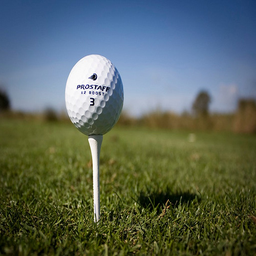

In [29]:
#"strength for noising/unnoising. 1.0 corresponds to full destruction of information in init image"
image_path = 'data/imagenette2/train/n03445777/ILSVRC2012_val_00002314.JPEG'
n_samples_per_class = batch_size = 3


init_image, pil_image = load_img(image_path)
display(pil_image)

### Getting a classifier from torch vision

In [30]:
device

'cpu'

In [31]:
classifier_model=getattr(torchvision.models, "efficientnet_b0")(pretrained=True).to(device)
classifier_model = classifier_model.eval()
classifier_model.train = disabled_train


#resize image to 224x224
init_image_resized = F.interpolate(normalize(init_image), size=(224, 224), mode='bilinear', align_corners=False).to(device)
classifier_model(init_image_resized).argmax(dim=1)
#classifier_model.classifier[-1] = Linear(classifier_model.classifier[-1].in_features, 11)

[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.


tensor([574])

### Getting a model, latent and wrapping in sampler

In [32]:
model = get_model()

Loading model from models/ldm/cin256-v2/model.ckpt
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 400.92 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels


In [33]:
image_path = 'data/imagenette2/train/n03445777/ILSVRC2012_val_00002314.JPEG'

strength = 0.36 #48#46#"strength for noising/unnoising. 1.0 corresponds to full destruction of information in init image"
n_samples_per_class = batch_size = 3
ddim_steps = 250
ddim_eta = 0.0
scale = 3.0   # for unconditional guidance


In [34]:

sampler = CCDDIMSampler(model, classifier_model)
sampler.make_schedule(ddim_num_steps=ddim_steps, ddim_eta=ddim_eta, verbose=False)
t_enc = int(strength * ddim_steps)


RuntimeError: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW

In [ ]:
init_image, pil_image = load_img(image_path)
init_image = init_image.to(device)
init_image = repeat(init_image, '1 ... -> b ...', b=n_samples_per_class)

# plot init image

In [ ]:
mapped_image = _unmap_img(init_image)
init_latent = model.get_first_stage_encoding(model.encode_first_stage(_unmap_img(init_image))) # move to latent space

### Creating the Counterfactual sampler


let's try first the classifier free sampling

In [ ]:
### Classifier free testing
sampler.masked_guidance = False 
sampler.lp_custom = 0
sampler.init_images = init_image
sampler.init_labels = n_samples_per_class*[574]
sampler.seg_model = None

all_samples =generate_samples(model, sampler, classes, n_samples_per_class, ddim_steps, scale, init_latent=init_latent, t_enc=t_enc, init_image=init_image, ccdddim=True)
# display as grid
grid = torch.stack(all_samples, 0)
grid = rearrange(grid, 'n b c h w -> (n b) c h w')
grid = make_grid(grid, nrow=n_samples_per_class+1)

# to image
grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
Image.fromarray(grid.astype(np.uint8))

### guidance to same class 

In [ ]:
### Classifier free testing
classes_neutral = 1*[574]
sampler.masked_guidance = False 
sampler.lp_custom = 0
sampler.init_images = init_image
sampler.init_labels = n_samples_per_class*[574]
sampler.seg_model = None

all_samples =generate_samples(model, sampler, classes_neutral, n_samples_per_class, ddim_steps, scale=3., init_latent=init_latent, t_enc=t_enc, init_image=init_image, ccdddim=True)
# display as grid
grid = torch.stack(all_samples, 0)
grid = rearrange(grid, 'n b c h w -> (n b) c h w')
grid = make_grid(grid, nrow=n_samples_per_class+1)

# to image
grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
Image.fromarray(grid.astype(np.uint8))

### No guidance

In [ ]:
### Classifier free testing
classes_neutral = n_samples_per_class*[1000]
sampler.masked_guidance = False 
sampler.lp_custom = 0
sampler.init_images = init_image
sampler.init_labels = n_samples_per_class*[574]
sampler.seg_model = None

all_samples =generate_samples(model, sampler, classes_neutral, n_samples_per_class, ddim_steps, scale=1., init_latent=init_latent, t_enc=t_enc, init_image=init_image, ccdddim=True)
# display as grid
grid = torch.stack(all_samples, 0)
grid = rearrange(grid, 'n b c h w -> (n b) c h w')
grid = make_grid(grid, nrow=n_samples_per_class+1)

# to image
grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
Image.fromarray(grid.astype(np.uint8))

### Classifier free testing

In [ ]:
sampler.masked_guidance = False 
sampler.lp_custom = 0
sampler.init_images = init_image
sampler.init_labels = n_samples_per_class*[574]
sampler.seg_model = None

all_samples =generate_samples(model, sampler, classes, n_samples_per_class, ddim_steps, scale, init_latent=init_latent, t_enc=t_enc, init_image=init_image, ccdddim=True)
# display as grid
grid = torch.stack(all_samples, 0)
grid = rearrange(grid, 'n b c h w -> (n b) c h w')
grid = make_grid(grid, nrow=n_samples_per_class+1)

# to image
grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
Image.fromarray(grid.astype(np.uint8))

### Classifier free testing with masking


In [ ]:
masked_image_renorm = renormalize(sampler.get_mask()*sampler.init_images, sampler.init_images)[0]

In [ ]:
masked_image_renorm.mean(), (sampler.get_mask()*sampler.init_images).mean(), sampler.init_images.mean()

In [ ]:
# plot masked image
plt.imshow(masked_image_renorm[0].permute(1, 2, 0).cpu().numpy())

In [ ]:
sampler.masked_guidance = True 
sampler.lp_custom = 0
sampler.init_images = init_image
sampler.init_labels = n_samples_per_class*[574]
sampler.seg_model = model_seg

In [ ]:
all_samples = list()

with torch.no_grad():
    #with precision_scope("cuda"):
    with model.ema_scope():

        tic = time.time()
        uc = model.get_learned_conditioning(
            {model.cond_stage_key: torch.tensor(n_samples_per_class*[1000]).to(model.device)}
            )
        
        for class_label in classes:
            
            print(f"rendering {n_samples_per_class} examples of class '{class_label}' in {ddim_steps} steps and using s={scale:.2f}.")
            xc = torch.tensor(n_samples_per_class*[class_label])
            c = model.get_learned_conditioning({model.cond_stage_key: xc.to(model.device)})
            z_enc = sampler.stochastic_encode(init_latent, torch.tensor([t_enc]*(n_samples_per_class)).to(device))
            # decode it
            samples = sampler.decode(z_enc, c, t_enc, unconditional_guidance_scale=scale,
                                      unconditional_conditioning=uc,)

            x_samples = model.decode_first_stage(samples)
            x_samples_ddim = torch.clamp((x_samples + 1.0) / 2.0, min=0.0, max=1.0)

            cat_samples=torch.cat([init_image[:1], x_samples_ddim], dim=0)
            all_samples.append(cat_samples)



# display as grid
grid = torch.stack(all_samples, 0)
grid = rearrange(grid, 'n b c h w -> (n b) c h w')
grid = make_grid(grid, nrow=n_samples_per_class+1)

# to image
grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
Image.fromarray(grid.astype(np.uint8))

### Now changing to the classifier guided without normalization

In [ ]:
scale

In [ ]:
strength = 0.4
t_enc = int(strength * ddim_steps)

sampler.guidance = "projected"
sampler.classifier_lambda = 5#5.5
sampler.enforce_same_norms = False


In [ ]:
all_samples =generate_samples(model, sampler, classes, n_samples_per_class, ddim_steps, scale, init_latent=init_latent, t_enc=t_enc, init_image=init_image, ccdddim=True)

# display as grid
grid = torch.stack(all_samples, 0)
grid = rearrange(grid, 'n b c h w -> (n b) c h w')
grid = make_grid(grid, nrow=n_samples_per_class+1)

# to image
grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
Image.fromarray(grid.astype(np.uint8))
# display as grid
grid = torch.stack(all_samples, 0)
grid = rearrange(grid, 'n b c h w -> (n b) c h w')
grid = make_grid(grid, nrow=n_samples_per_class+1)

# to image
grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
Image.fromarray(grid.astype(np.uint8))

### Now changing to the classifier guided with Normalization

#### Without mask

In [ ]:
ddim_steps

In [ ]:
strength = 0.4#0.4
t_enc = int(strength * ddim_steps)

sampler.enforce_same_norms = True
sampler.masked_dist = False
sampler.guidance = "projected"
sampler.classifier_lambda = 2.5 # 5.5 best 
sampler.dist_lambda = 0
sampler.lp_custom = 0
sampler.init_images = init_image


In [ ]:
all_samples =generate_samples(model, sampler, classes[1:2], n_samples_per_class, ddim_steps, scale, init_latent=init_latent, t_enc=t_enc, init_image=init_image, ccdddim=True)


# display as grid
grid = torch.stack(all_samples, 0)
grid = rearrange(grid, 'n b c h w -> (n b) c h w')
grid = make_grid(grid, nrow=n_samples_per_class+1)


# to image
grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
Image.fromarray(grid.astype(np.uint8))


#### with mask

In [ ]:

sampler.enforce_same_norms = True
sampler.masked_guidance = True
sampler.masked_dist = False
sampler.init_images = init_image
sampler.init_labels = n_samples_per_class*[574]
sampler.seg_model = model_seg
sampler.guidance = "projected"
sampler.classifier_lambda = 3 #5.5 # 5.5 best 
sampler.dist_lambda = 0
sampler.lp_custom = 0
sampler.init_images = init_image

all_samples =generate_samples(model, sampler, classes[1:2], n_samples_per_class, ddim_steps, scale, init_latent=init_latent, t_enc=t_enc, init_image=init_image, ccdddim=True)


# display as grid
grid = torch.stack(all_samples, 0)
grid = rearrange(grid, 'n b c h w -> (n b) c h w')
grid = make_grid(grid, nrow=n_samples_per_class+1)

# to image
grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
Image.fromarray(grid.astype(np.uint8))



### Now changing to the classifier guided with Normalization and distance 

In [ ]:

image_path = 'data/imagenette2/train/n03445777/ILSVRC2012_val_00002314.JPEG'

strength = 0.48 #48#46#"strength for noising/unnoising. 1.0 corresponds to full destruction of information in init image"
n_samples_per_class = batch_size = 3
ddim_steps = 250
ddim_eta = 0.0
scale = 3.0   # for unconditional guidance

sampler = CCDDIMSampler(model, classifier_model)
sampler.make_schedule(ddim_num_steps=ddim_steps, ddim_eta=ddim_eta, verbose=False)
t_enc = int(strength * ddim_steps)

In [ ]:
t_enc

In [ ]:
sampler.ddim_timesteps[t_enc]

In [ ]:
sampler.enforce_same_norms = True
sampler.masked_dist = False
sampler.guidance = "projected"
sampler.classifier_lambda = 0.1 #2.5 # 5.5 best 
sampler.dist_lambda = 0.1
sampler.lp_custom = 1
sampler.init_images = init_image

In [ ]:
for lam_dist in [0.2]:#[0.03 ,0.1, -0.1, 0.3, -0.3, 0.9, 1e-6]:
    image_path = 'data/imagenette2/train/n03445777/ILSVRC2012_val_00002314.JPEG'

    strength = 0.4 #48#46#"strength for noising/unnoising. 1.0 corresponds to full destruction of information in init image"
    n_samples_per_class = batch_size = 3
    
    ddim_steps = 250
    ddim_eta = 0.0
    scale = 3.0   # for unconditional guidance

    sampler = CCDDIMSampler(model, classifier_model)
    sampler.make_schedule(ddim_num_steps=ddim_steps, ddim_eta=ddim_eta, verbose=False)
    t_enc = int(strength * ddim_steps)
    sampler.enforce_same_norms = True
    sampler.masked_dist = False
    sampler.guidance = "projected"
    sampler.classifier_lambda = 3 #2.5 # 5.5 best 
    sampler.dist_lambda = lam_dist
    sampler.lp_custom = 1
    sampler.init_images = init_image

    all_samples =generate_samples(model, sampler, classes[1:2], n_samples_per_class, ddim_steps, scale, init_latent=init_latent, t_enc=t_enc, init_image=init_image, ccdddim=True)


    # display as grid
    grid = torch.stack(all_samples, 0)
    grid = rearrange(grid, 'n b c h w -> (n b) c h w')
    grid = make_grid(grid, nrow=n_samples_per_class+1)

    # to image
    grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
    Image.fromarray(grid.astype(np.uint8))


## Now generating for the images of interest 

In [35]:
torch.autograd.set_detect_anomaly(True)

In [ ]:
strength = 0.4#0.28#48#46#"strength for noising/unnoising. 1.0 corresponds to full destruction of information in init image"
ddim_steps = 500
sampler = CCDDIMSampler(model, classifier_model)
sampler.make_schedule(ddim_num_steps=ddim_steps, ddim_eta=ddim_eta, verbose=False)

assert 0. <= strength <= 1., 'can only work with strength in [0.0, 1.0]'
t_enc = int(strength * ddim_steps)
precision = "autocast" #"full"
precision_scope = autocast if precision == "autocast" else nullcontext
n_samples_per_class = 3

sampler.enforce_same_norms = True
sampler.guidance = "projected"
sampler.classifier_lambda = 1 #.2 #1.8 #2 final #1.5 #2.5 # 5.5 best 
sampler.dist_lambda = 1 # 0.15
sampler.masked_dist = False
sampler.masked_guidance = False
#sampler.seg_model = model_seg

sampler.lp_custom = 1 

In [ ]:
# strength = 0.5 #0.3#48#46#"strength for noising/unnoising. 1.0 corresponds to full destruction of information in init image"
# ddim_steps = 500 #200
# sampler = CCDDIMSampler(model, classifier_model)
# sampler.make_schedule(ddim_num_steps=ddim_steps, ddim_eta=ddim_eta, verbose=False)

# assert 0. <= strength <= 1., 'can only work with strength in [0.0, 1.0]'
# t_enc = int(strength * ddim_steps)

# precision = "autocast" #"full"
# precision_scope = autocast if precision == "autocast" else nullcontext
# n_samples_per_class = 3

# sampler.enforce_same_norms = True
# sampler.guidance = "projected"
# sampler.classifier_lambda = 2.2 #2 final #1.5 #2.5 # 5.5 best 
# sampler.dist_lambda = 0.2
# sampler.masked_dist = False
# sampler.masked_guidance = False
# #sampler.seg_model = model_seg

# sampler.lp_custom = 1 

In [ ]:
t_enc


In [ ]:

for key, value in orig_vces.items():
    
    some_value = some_vces[key]
    print(f"Key: {key}, Orig Value: {value}, Some Value: {some_value}")
    classes = some_value
    init_image = dataset[key][0].repeat(n_samples_per_class, 1, 1, 1).to(device)
    plt.imshow(init_image[0].permute(1, 2, 0).detach().cpu().numpy())
    plt.show()
    sampler.init_images = init_image
    sampler.init_labels = n_samples_per_class*[value]


    #print(init_image.min(), init_image.max() )
    # plot init image
    mapped_image = _unmap_img(init_image)
    print(mapped_image.min(), mapped_image.max() )
    init_latent = model.get_first_stage_encoding(model.encode_first_stage(_unmap_img(init_image))) # move to latent space

    all_samples =generate_samples(model, sampler, classes, n_samples_per_class, ddim_steps, scale, init_latent=init_latent, t_enc=t_enc, init_image=init_image, ccdddim=True)


    # display as grid
    grid = torch.stack(all_samples, 0)
    grid = rearrange(grid, 'n b c h w -> (n b) c h w')
    grid = make_grid(grid, nrow=n_samples_per_class+1)

    # to image
    grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
    img = Image.fromarray(grid.astype(np.uint8))
    #save 
    save_path = f"generation_process_{value}_{some_value}_cc_{sampler.classifier_lambda}_cd_{sampler.dist_lambda}_s_{strength}_ds_{ddim_steps}.png"
    img.save(save_path)
    

In [57]:
strength = 0.5#0.28#48#46#"strength for noising/unnoising. 1.0 corresponds to full destruction of information in init image"
ddim_steps = 250
sampler = CCDDIMSampler(model, classifier_model)
sampler.make_schedule(ddim_num_steps=ddim_steps, ddim_eta=ddim_eta, verbose=False)

assert 0. <= strength <= 1., 'can only work with strength in [0.0, 1.0]'
t_enc = int(strength * ddim_steps)
precision = "autocast" #"full"
precision_scope = autocast if precision == "autocast" else nullcontext
n_samples_per_class = 3

sampler.enforce_same_norms = True
sampler.guidance = "projected"
sampler.classifier_lambda = 1 #.2 #1.8 #2 final #1.5 #2.5 # 5.5 best 
sampler.dist_lambda = 1 # 0.15
sampler.masked_dist = False
sampler.masked_guidance = False
#sampler.seg_model = model_seg

sampler.lp_custom = 1 


for key, value in orig_vces.items():
    
    some_value = some_vces[key]
    print(f"Key: {key}, Orig Value: {value}, Some Value: {some_value}")
    classes = some_value
    init_image = dataset[key][0].repeat(n_samples_per_class, 1, 1, 1).to(device)
    plt.imshow(init_image[0].permute(1, 2, 0).detach().cpu().numpy())
    plt.show()
    sampler.init_images = init_image
    sampler.init_labels = n_samples_per_class*[value]


    #print(init_image.min(), init_image.max() )
    # plot init image
    mapped_image = _unmap_img(init_image)
    print(mapped_image.min(), mapped_image.max() )
    init_latent = model.get_first_stage_encoding(model.encode_first_stage(_unmap_img(init_image))) # move to latent space

    all_samples =generate_samples(model, sampler, classes, n_samples_per_class, ddim_steps, scale, init_latent=init_latent, t_enc=t_enc, init_image=init_image, ccdddim=True)


    # display as grid
    grid = torch.stack(all_samples, 0)
    grid = rearrange(grid, 'n b c h w -> (n b) c h w')
    grid = make_grid(grid, nrow=n_samples_per_class+1)

    # to image
    grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
    img = Image.fromarray(grid.astype(np.uint8))
    #save 
    save_path = f"generation_process_{value}_{some_value}_cc_{sampler.classifier_lambda}_cd_{sampler.dist_lambda}_s_{strength}_ds_{ddim_steps}.png"
    img.save(save_path)
    

Decoding image:  33%|███▎      | 41/125 [03:38<07:26,  5.31s/it]

prob_best_class tensor(0.0006, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  34%|███▎      | 42/125 [03:43<07:19,  5.30s/it]

prob_best_class tensor(0.0008, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  34%|███▍      | 43/125 [03:48<07:13,  5.28s/it]

prob_best_class tensor(0.0012, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  35%|███▌      | 44/125 [03:53<07:07,  5.27s/it]

prob_best_class tensor(0.0018, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  36%|███▌      | 45/125 [03:59<07:01,  5.27s/it]

prob_best_class tensor(0.0027, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  37%|███▋      | 46/125 [04:04<06:55,  5.26s/it]

prob_best_class tensor(0.0036, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  38%|███▊      | 47/125 [04:09<06:50,  5.26s/it]

prob_best_class tensor(0.0045, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  38%|███▊      | 48/125 [04:14<06:44,  5.25s/it]

prob_best_class tensor(0.0062, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  39%|███▉      | 49/125 [04:20<06:39,  5.26s/it]

prob_best_class tensor(0.0080, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  40%|████      | 50/125 [04:25<06:34,  5.25s/it]

prob_best_class tensor(0.0115, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  41%|████      | 51/125 [04:30<06:28,  5.25s/it]

prob_best_class tensor(0.0150, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  42%|████▏     | 52/125 [04:35<06:23,  5.25s/it]

prob_best_class tensor(0.0197, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  42%|████▏     | 53/125 [04:41<06:18,  5.25s/it]

prob_best_class tensor(0.0284, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  43%|████▎     | 54/125 [04:46<06:13,  5.26s/it]

prob_best_class tensor(0.0346, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  44%|████▍     | 55/125 [04:51<06:08,  5.26s/it]

prob_best_class tensor(0.0385, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  45%|████▍     | 56/125 [04:56<06:02,  5.26s/it]

prob_best_class tensor(0.0404, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  46%|████▌     | 57/125 [05:02<05:57,  5.26s/it]

prob_best_class tensor(0.0492, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  46%|████▋     | 58/125 [05:07<05:52,  5.26s/it]

prob_best_class tensor(0.0614, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  47%|████▋     | 59/125 [05:12<05:46,  5.26s/it]

prob_best_class tensor(0.0699, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  48%|████▊     | 60/125 [05:17<05:41,  5.25s/it]

prob_best_class tensor(0.0858, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  49%|████▉     | 61/125 [05:23<05:36,  5.25s/it]

prob_best_class tensor(0.0958, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  50%|████▉     | 62/125 [05:28<05:30,  5.25s/it]

prob_best_class tensor(0.1128, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  50%|█████     | 63/125 [05:33<05:26,  5.26s/it]

prob_best_class tensor(0.1301, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  51%|█████     | 64/125 [05:38<05:20,  5.26s/it]

prob_best_class tensor(0.1483, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  52%|█████▏    | 65/125 [05:44<05:15,  5.26s/it]

prob_best_class tensor(0.1772, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  53%|█████▎    | 66/125 [05:49<05:10,  5.26s/it]

prob_best_class tensor(0.2125, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  54%|█████▎    | 67/125 [05:54<05:04,  5.26s/it]

prob_best_class tensor(0.2331, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  54%|█████▍    | 68/125 [05:59<04:59,  5.26s/it]

prob_best_class tensor(0.2500, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  55%|█████▌    | 69/125 [06:05<04:54,  5.26s/it]

prob_best_class tensor(0.2832, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  56%|█████▌    | 70/125 [06:10<04:48,  5.25s/it]

prob_best_class tensor(0.3043, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  57%|█████▋    | 71/125 [06:15<04:43,  5.25s/it]

prob_best_class tensor(0.3499, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  58%|█████▊    | 72/125 [06:20<04:38,  5.25s/it]

prob_best_class tensor(0.3773, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  58%|█████▊    | 73/125 [06:26<04:32,  5.25s/it]

prob_best_class tensor(0.4151, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  59%|█████▉    | 74/125 [06:31<04:27,  5.25s/it]

prob_best_class tensor(0.4514, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  60%|██████    | 75/125 [06:36<04:22,  5.25s/it]

prob_best_class tensor(0.4818, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  61%|██████    | 76/125 [06:41<04:17,  5.26s/it]

prob_best_class tensor(0.5126, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  62%|██████▏   | 77/125 [06:47<04:12,  5.25s/it]

prob_best_class tensor(0.5566, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  62%|██████▏   | 78/125 [06:52<04:06,  5.25s/it]

prob_best_class tensor(0.5817, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  63%|██████▎   | 79/125 [06:57<04:01,  5.25s/it]

prob_best_class tensor(0.6155, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  64%|██████▍   | 80/125 [07:02<03:56,  5.25s/it]

prob_best_class tensor(0.6383, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  65%|██████▍   | 81/125 [07:08<03:50,  5.25s/it]

prob_best_class tensor(0.6787, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  66%|██████▌   | 82/125 [07:13<03:45,  5.25s/it]

prob_best_class tensor(0.7171, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  66%|██████▋   | 83/125 [07:18<03:40,  5.25s/it]

prob_best_class tensor(0.7544, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  67%|██████▋   | 84/125 [07:23<03:35,  5.25s/it]

prob_best_class tensor(0.7726, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  68%|██████▊   | 85/125 [07:29<03:29,  5.25s/it]

prob_best_class tensor(0.7851, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  69%|██████▉   | 86/125 [07:34<03:24,  5.25s/it]

prob_best_class tensor(0.8075, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  70%|██████▉   | 87/125 [07:39<03:19,  5.25s/it]

prob_best_class tensor(0.8240, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  70%|███████   | 88/125 [07:44<03:14,  5.25s/it]

prob_best_class tensor(0.8467, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  71%|███████   | 89/125 [07:50<03:08,  5.25s/it]

prob_best_class tensor(0.8638, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  72%|███████▏  | 90/125 [07:55<03:03,  5.25s/it]

prob_best_class tensor(0.8848, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  73%|███████▎  | 91/125 [08:00<02:58,  5.25s/it]

prob_best_class tensor(0.8894, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  74%|███████▎  | 92/125 [08:05<02:53,  5.25s/it]

prob_best_class tensor(0.9018, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  74%|███████▍  | 93/125 [08:11<02:47,  5.25s/it]

prob_best_class tensor(0.9106, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  75%|███████▌  | 94/125 [08:16<02:42,  5.25s/it]

prob_best_class tensor(0.9198, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  76%|███████▌  | 95/125 [08:21<02:37,  5.25s/it]

prob_best_class tensor(0.9273, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  77%|███████▋  | 96/125 [08:26<02:32,  5.24s/it]

prob_best_class tensor(0.9271, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  78%|███████▊  | 97/125 [08:32<02:26,  5.24s/it]

prob_best_class tensor(0.9298, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  78%|███████▊  | 98/125 [08:37<02:21,  5.24s/it]

prob_best_class tensor(0.9334, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  79%|███████▉  | 99/125 [08:42<02:16,  5.25s/it]

prob_best_class tensor(0.9415, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  80%|████████  | 100/125 [08:47<02:11,  5.25s/it]

prob_best_class tensor(0.9444, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  81%|████████  | 101/125 [08:53<02:05,  5.25s/it]

prob_best_class tensor(0.9480, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  82%|████████▏ | 102/125 [08:58<02:00,  5.24s/it]

prob_best_class tensor(0.9490, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  82%|████████▏ | 103/125 [09:03<01:55,  5.24s/it]

prob_best_class tensor(0.9529, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  83%|████████▎ | 104/125 [09:08<01:49,  5.24s/it]

prob_best_class tensor(0.9611, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  84%|████████▍ | 105/125 [09:14<01:44,  5.24s/it]

prob_best_class tensor(0.9665, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  85%|████████▍ | 106/125 [09:19<01:39,  5.24s/it]

prob_best_class tensor(0.9677, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  86%|████████▌ | 107/125 [09:24<01:36,  5.37s/it]

prob_best_class tensor(0.9714, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  86%|████████▋ | 108/125 [09:30<01:30,  5.33s/it]

prob_best_class tensor(0.9736, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  87%|████████▋ | 109/125 [09:35<01:24,  5.30s/it]

prob_best_class tensor(0.9753, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  88%|████████▊ | 110/125 [09:40<01:19,  5.28s/it]

prob_best_class tensor(0.9761, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  89%|████████▉ | 111/125 [09:45<01:13,  5.26s/it]

prob_best_class tensor(0.9776, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  90%|████████▉ | 112/125 [09:51<01:08,  5.25s/it]

prob_best_class tensor(0.9782, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  90%|█████████ | 113/125 [09:56<01:03,  5.25s/it]

prob_best_class tensor(0.9805, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  91%|█████████ | 114/125 [10:01<00:57,  5.25s/it]

prob_best_class tensor(0.9812, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  92%|█████████▏| 115/125 [10:06<00:52,  5.25s/it]

prob_best_class tensor(0.9832, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  93%|█████████▎| 116/125 [10:12<00:47,  5.24s/it]

prob_best_class tensor(0.9837, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  94%|█████████▎| 117/125 [10:17<00:41,  5.24s/it]

prob_best_class tensor(0.9844, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  94%|█████████▍| 118/125 [10:22<00:36,  5.24s/it]

prob_best_class tensor(0.9855, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  95%|█████████▌| 119/125 [10:27<00:31,  5.23s/it]

prob_best_class tensor(0.9869, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  96%|█████████▌| 120/125 [10:32<00:26,  5.23s/it]

prob_best_class tensor(0.9888, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  97%|█████████▋| 121/125 [10:38<00:20,  5.23s/it]

prob_best_class tensor(0.9893, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  98%|█████████▊| 122/125 [10:43<00:15,  5.23s/it]

prob_best_class tensor(0.9905, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  98%|█████████▊| 123/125 [10:48<00:10,  5.23s/it]

prob_best_class tensor(0.9917, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  99%|█████████▉| 124/125 [10:53<00:05,  5.23s/it]

prob_best_class tensor(0.9928, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image: 100%|██████████| 125/125 [10:59<00:00,  5.27s/it]


Saved gif of generation process to generation_process_963_cc_1_cd_1_ts_125_tts_497_125_conf_0.992789626121521.mp4
rendering 3 examples of class '965' in 250 steps and using s=3.00.
Running DDIM Sampling with 125 timesteps


Decoding image:   0%|          | 0/125 [00:00<?, ?it/s]

prob_best_class tensor(1.2221e-08, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:   1%|          | 1/125 [00:05<11:24,  5.52s/it]

prob_best_class tensor(3.1437e-08, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:   2%|▏         | 2/125 [00:10<10:57,  5.35s/it]

prob_best_class tensor(1.1779e-07, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:   2%|▏         | 3/125 [00:15<10:45,  5.29s/it]

prob_best_class tensor(3.4493e-07, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:   3%|▎         | 4/125 [00:21<10:37,  5.27s/it]

prob_best_class tensor(9.1804e-07, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:   4%|▍         | 5/125 [00:26<10:30,  5.26s/it]

prob_best_class tensor(3.2498e-06, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:   5%|▍         | 6/125 [00:31<10:24,  5.25s/it]

prob_best_class tensor(9.6850e-06, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:   6%|▌         | 7/125 [00:36<10:19,  5.25s/it]

prob_best_class tensor(2.5547e-05, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:   6%|▋         | 8/125 [00:42<10:13,  5.24s/it]

prob_best_class tensor(7.5393e-05, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:   7%|▋         | 9/125 [00:47<10:08,  5.25s/it]

prob_best_class tensor(0.0002, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:   8%|▊         | 10/125 [00:52<10:02,  5.24s/it]

prob_best_class tensor(0.0005, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:   9%|▉         | 11/125 [00:57<09:56,  5.24s/it]

prob_best_class tensor(0.0011, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  10%|▉         | 12/125 [01:03<09:52,  5.24s/it]

prob_best_class tensor(0.0027, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  10%|█         | 13/125 [01:08<09:46,  5.24s/it]

prob_best_class tensor(0.0050, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  11%|█         | 14/125 [01:13<09:41,  5.24s/it]

prob_best_class tensor(0.0087, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  12%|█▏        | 15/125 [01:18<09:36,  5.24s/it]

prob_best_class tensor(0.0123, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  13%|█▎        | 16/125 [01:24<09:30,  5.24s/it]

prob_best_class tensor(0.0180, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  14%|█▎        | 17/125 [01:29<09:25,  5.24s/it]

prob_best_class tensor(0.0244, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  14%|█▍        | 18/125 [01:34<09:20,  5.23s/it]

prob_best_class tensor(0.0356, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  15%|█▌        | 19/125 [01:39<09:15,  5.24s/it]

prob_best_class tensor(0.0406, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  16%|█▌        | 20/125 [01:44<09:09,  5.24s/it]

prob_best_class tensor(0.0494, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  17%|█▋        | 21/125 [01:50<09:04,  5.24s/it]

prob_best_class tensor(0.0584, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  18%|█▊        | 22/125 [01:55<08:59,  5.24s/it]

prob_best_class tensor(0.0631, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  18%|█▊        | 23/125 [02:00<08:54,  5.24s/it]

prob_best_class tensor(0.0835, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  19%|█▉        | 24/125 [02:05<08:48,  5.24s/it]

prob_best_class tensor(0.0955, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  20%|██        | 25/125 [02:11<08:43,  5.24s/it]

prob_best_class tensor(0.1031, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  21%|██        | 26/125 [02:16<08:38,  5.24s/it]

prob_best_class tensor(0.1206, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  22%|██▏       | 27/125 [02:21<08:33,  5.24s/it]

prob_best_class tensor(0.1461, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  22%|██▏       | 28/125 [02:26<08:28,  5.24s/it]

prob_best_class tensor(0.1720, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  23%|██▎       | 29/125 [02:32<08:22,  5.24s/it]

prob_best_class tensor(0.1936, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  24%|██▍       | 30/125 [02:37<08:17,  5.24s/it]

prob_best_class tensor(0.2248, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  25%|██▍       | 31/125 [02:42<08:12,  5.24s/it]

prob_best_class tensor(0.2475, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  26%|██▌       | 32/125 [02:47<08:07,  5.24s/it]

prob_best_class tensor(0.2922, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  26%|██▋       | 33/125 [02:53<08:01,  5.24s/it]

prob_best_class tensor(0.3067, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  27%|██▋       | 34/125 [02:58<07:56,  5.23s/it]

prob_best_class tensor(0.3073, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  28%|██▊       | 35/125 [03:03<07:50,  5.23s/it]

prob_best_class tensor(0.3256, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  29%|██▉       | 36/125 [03:08<07:45,  5.23s/it]

prob_best_class tensor(0.3490, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  30%|██▉       | 37/125 [03:14<07:40,  5.23s/it]

prob_best_class tensor(0.3702, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  30%|███       | 38/125 [03:19<07:35,  5.23s/it]

prob_best_class tensor(0.4230, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  31%|███       | 39/125 [03:24<07:30,  5.23s/it]

prob_best_class tensor(0.4362, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  32%|███▏      | 40/125 [03:29<07:25,  5.24s/it]

prob_best_class tensor(0.4804, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  33%|███▎      | 41/125 [03:34<07:19,  5.24s/it]

prob_best_class tensor(0.5157, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  34%|███▎      | 42/125 [03:40<07:14,  5.24s/it]

prob_best_class tensor(0.5695, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  34%|███▍      | 43/125 [03:45<07:09,  5.24s/it]

prob_best_class tensor(0.5754, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  35%|███▌      | 44/125 [03:50<07:04,  5.24s/it]

prob_best_class tensor(0.5924, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  36%|███▌      | 45/125 [03:55<06:59,  5.24s/it]

prob_best_class tensor(0.5958, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  37%|███▋      | 46/125 [04:01<06:54,  5.24s/it]

prob_best_class tensor(0.6310, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  38%|███▊      | 47/125 [04:06<06:48,  5.24s/it]

prob_best_class tensor(0.6761, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  38%|███▊      | 48/125 [04:11<06:43,  5.24s/it]

prob_best_class tensor(0.7068, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  39%|███▉      | 49/125 [04:16<06:38,  5.24s/it]

prob_best_class tensor(0.7328, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  40%|████      | 50/125 [04:22<06:33,  5.24s/it]

prob_best_class tensor(0.7522, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  41%|████      | 51/125 [04:27<06:27,  5.24s/it]

prob_best_class tensor(0.7739, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  42%|████▏     | 52/125 [04:32<06:22,  5.24s/it]

prob_best_class tensor(0.7995, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  42%|████▏     | 53/125 [04:37<06:17,  5.25s/it]

prob_best_class tensor(0.8205, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  43%|████▎     | 54/125 [04:43<06:12,  5.24s/it]

prob_best_class tensor(0.8485, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  44%|████▍     | 55/125 [04:48<06:07,  5.25s/it]

prob_best_class tensor(0.8724, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  45%|████▍     | 56/125 [04:53<06:01,  5.25s/it]

prob_best_class tensor(0.8930, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  46%|████▌     | 57/125 [04:58<05:56,  5.25s/it]

prob_best_class tensor(0.9010, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  46%|████▋     | 58/125 [05:04<05:51,  5.24s/it]

prob_best_class tensor(0.9121, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  47%|████▋     | 59/125 [05:09<05:45,  5.24s/it]

prob_best_class tensor(0.9262, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  48%|████▊     | 60/125 [05:14<05:40,  5.24s/it]

prob_best_class tensor(0.9327, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  49%|████▉     | 61/125 [05:19<05:35,  5.24s/it]

prob_best_class tensor(0.9390, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  50%|████▉     | 62/125 [05:25<05:30,  5.24s/it]

prob_best_class tensor(0.9477, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  50%|█████     | 63/125 [05:30<05:25,  5.24s/it]

prob_best_class tensor(0.9539, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  51%|█████     | 64/125 [05:35<05:19,  5.24s/it]

prob_best_class tensor(0.9608, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  52%|█████▏    | 65/125 [05:40<05:14,  5.24s/it]

prob_best_class tensor(0.9656, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  53%|█████▎    | 66/125 [05:46<05:09,  5.24s/it]

prob_best_class tensor(0.9674, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  54%|█████▎    | 67/125 [05:51<05:04,  5.25s/it]

prob_best_class tensor(0.9710, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  54%|█████▍    | 68/125 [05:56<04:58,  5.24s/it]

prob_best_class tensor(0.9744, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  55%|█████▌    | 69/125 [06:02<05:01,  5.39s/it]

prob_best_class tensor(0.9772, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  56%|█████▌    | 70/125 [06:07<04:53,  5.34s/it]

prob_best_class tensor(0.9788, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  57%|█████▋    | 71/125 [06:12<04:46,  5.31s/it]

prob_best_class tensor(0.9817, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  58%|█████▊    | 72/125 [06:17<04:40,  5.29s/it]

prob_best_class tensor(0.9827, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  58%|█████▊    | 73/125 [06:23<04:34,  5.28s/it]

prob_best_class tensor(0.9851, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  59%|█████▉    | 74/125 [06:28<04:28,  5.26s/it]

prob_best_class tensor(0.9859, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  60%|██████    | 75/125 [06:33<04:22,  5.26s/it]

prob_best_class tensor(0.9884, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  61%|██████    | 76/125 [06:38<04:17,  5.26s/it]

prob_best_class tensor(0.9895, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  62%|██████▏   | 77/125 [06:44<04:12,  5.25s/it]

prob_best_class tensor(0.9905, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  62%|██████▏   | 78/125 [06:49<04:06,  5.25s/it]

prob_best_class tensor(0.9916, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  63%|██████▎   | 79/125 [06:54<04:01,  5.25s/it]

prob_best_class tensor(0.9929, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  64%|██████▍   | 80/125 [06:59<03:56,  5.25s/it]

prob_best_class tensor(0.9937, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  65%|██████▍   | 81/125 [07:05<03:50,  5.25s/it]

prob_best_class tensor(0.9945, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  66%|██████▌   | 82/125 [07:10<03:45,  5.25s/it]

prob_best_class tensor(0.9955, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  66%|██████▋   | 83/125 [07:15<03:40,  5.25s/it]

prob_best_class tensor(0.9955, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  67%|██████▋   | 84/125 [07:20<03:34,  5.24s/it]

prob_best_class tensor(0.9959, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  68%|██████▊   | 85/125 [07:26<03:29,  5.25s/it]

prob_best_class tensor(0.9965, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  69%|██████▉   | 86/125 [07:31<03:24,  5.25s/it]

prob_best_class tensor(0.9973, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  70%|██████▉   | 87/125 [07:36<03:19,  5.24s/it]

prob_best_class tensor(0.9976, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  70%|███████   | 88/125 [07:41<03:14,  5.24s/it]

prob_best_class tensor(0.9978, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  71%|███████   | 89/125 [07:47<03:08,  5.24s/it]

prob_best_class tensor(0.9982, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  72%|███████▏  | 90/125 [07:52<03:03,  5.24s/it]

prob_best_class tensor(0.9984, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  73%|███████▎  | 91/125 [07:57<02:58,  5.24s/it]

prob_best_class tensor(0.9985, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  74%|███████▎  | 92/125 [08:02<02:52,  5.24s/it]

prob_best_class tensor(0.9987, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  74%|███████▍  | 93/125 [08:08<02:47,  5.24s/it]

prob_best_class tensor(0.9989, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  75%|███████▌  | 94/125 [08:13<02:42,  5.25s/it]

prob_best_class tensor(0.9990, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  76%|███████▌  | 95/125 [08:18<02:37,  5.25s/it]

prob_best_class tensor(0.9991, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  77%|███████▋  | 96/125 [08:23<02:31,  5.24s/it]

prob_best_class tensor(0.9992, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  78%|███████▊  | 97/125 [08:29<02:26,  5.24s/it]

prob_best_class tensor(0.9992, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  78%|███████▊  | 98/125 [08:34<02:21,  5.24s/it]

prob_best_class tensor(0.9993, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  79%|███████▉  | 99/125 [08:39<02:16,  5.24s/it]

prob_best_class tensor(0.9994, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  80%|████████  | 100/125 [08:44<02:10,  5.24s/it]

prob_best_class tensor(0.9994, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  81%|████████  | 101/125 [08:50<02:05,  5.24s/it]

prob_best_class tensor(0.9994, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  82%|████████▏ | 102/125 [08:55<02:00,  5.24s/it]

prob_best_class tensor(0.9995, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  82%|████████▏ | 103/125 [09:00<01:55,  5.24s/it]

prob_best_class tensor(0.9996, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  83%|████████▎ | 104/125 [09:05<01:50,  5.24s/it]

prob_best_class tensor(0.9996, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  84%|████████▍ | 105/125 [09:10<01:44,  5.24s/it]

prob_best_class tensor(0.9997, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  85%|████████▍ | 106/125 [09:16<01:39,  5.24s/it]

prob_best_class tensor(0.9997, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  86%|████████▌ | 107/125 [09:21<01:34,  5.24s/it]

prob_best_class tensor(0.9997, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  86%|████████▋ | 108/125 [09:26<01:29,  5.24s/it]

prob_best_class tensor(0.9998, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  87%|████████▋ | 109/125 [09:31<01:23,  5.24s/it]

prob_best_class tensor(0.9998, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  88%|████████▊ | 110/125 [09:37<01:18,  5.24s/it]

prob_best_class tensor(0.9998, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  89%|████████▉ | 111/125 [09:42<01:13,  5.24s/it]

prob_best_class tensor(0.9998, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  90%|████████▉ | 112/125 [09:47<01:08,  5.25s/it]

prob_best_class tensor(0.9998, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  90%|█████████ | 113/125 [09:52<01:03,  5.25s/it]

prob_best_class tensor(0.9999, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  91%|█████████ | 114/125 [09:58<00:57,  5.25s/it]

prob_best_class tensor(0.9999, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  92%|█████████▏| 115/125 [10:03<00:52,  5.25s/it]

prob_best_class tensor(0.9999, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  93%|█████████▎| 116/125 [10:08<00:47,  5.25s/it]

prob_best_class tensor(0.9999, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  94%|█████████▎| 117/125 [10:13<00:41,  5.25s/it]

prob_best_class tensor(0.9999, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  94%|█████████▍| 118/125 [10:19<00:36,  5.24s/it]

prob_best_class tensor(0.9999, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  95%|█████████▌| 119/125 [10:24<00:31,  5.24s/it]

prob_best_class tensor(0.9999, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  96%|█████████▌| 120/125 [10:29<00:26,  5.25s/it]

prob_best_class tensor(0.9999, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  97%|█████████▋| 121/125 [10:34<00:20,  5.25s/it]

prob_best_class tensor(0.9999, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  98%|█████████▊| 122/125 [10:40<00:15,  5.25s/it]

prob_best_class tensor(1.0000, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  98%|█████████▊| 123/125 [10:45<00:10,  5.25s/it]

prob_best_class tensor(1.0000, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image:  99%|█████████▉| 124/125 [10:50<00:05,  5.25s/it]

prob_best_class tensor(1.0000, device='cuda:1', grad_fn=<ExpBackward0>)


Decoding image: 100%|██████████| 125/125 [10:55<00:00,  5.25s/it]


Saved gif of generation process to generation_process_965_cc_1_cd_1_ts_125_tts_497_125_conf_0.9999733567237854.mp4


Key: 14655, Orig Value: 293, Some Value: [288, 292]


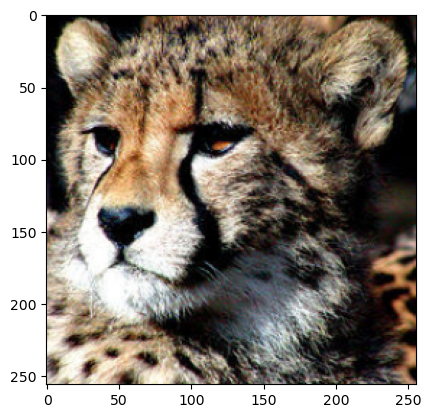

tensor(-1., device='cuda:1') tensor(1., device='cuda:1')
rendering 3 examples of class '288' in 250 steps and using s=3.00.
Running DDIM Sampling with 125 timesteps


Decoding image: 100%|██████████| 125/125 [05:32<00:00,  2.66s/it]


IndexError: list index out of range

In [59]:
strength = 0.5#0.28#48#46#"strength for noising/unnoising. 1.0 corresponds to full destruction of information in init image"
sampler.images = []
ddim_steps = 250
sampler = CCDDIMSampler(model, classifier_model)
sampler.make_schedule(ddim_num_steps=ddim_steps, ddim_eta=ddim_eta, verbose=False)

assert 0. <= strength <= 1., 'can only work with strength in [0.0, 1.0]'
t_enc = int(strength * ddim_steps)
precision = "autocast" #"full"
precision_scope = autocast if precision == "autocast" else nullcontext
n_samples_per_class = 3

sampler.enforce_same_norms = True
sampler.guidance = "projected"
sampler.classifier_lambda = 0#.2 #1.8 #2 final #1.5 #2.5 # 5.5 best 

sampler.dist_lambda = 1 # 0.15
sampler.masked_dist = False
sampler.masked_guidance = False
#sampler.seg_model = model_seg

sampler.lp_custom = 1 


for key, value in orig_vces.items():
    
    some_value = some_vces[key]
    print(f"Key: {key}, Orig Value: {value}, Some Value: {some_value}")
    classes = some_value
    init_image = dataset[key][0].repeat(n_samples_per_class, 1, 1, 1).to(device)
    plt.imshow(init_image[0].permute(1, 2, 0).detach().cpu().numpy())
    plt.show()
    sampler.init_images = init_image
    sampler.init_labels = n_samples_per_class*[value]


    #print(init_image.min(), init_image.max() )
    # plot init image
    mapped_image = _unmap_img(init_image)
    print(mapped_image.min(), mapped_image.max() )
    init_latent = model.get_first_stage_encoding(model.encode_first_stage(_unmap_img(init_image))) # move to latent space

    all_samples =generate_samples(model, sampler, classes, n_samples_per_class, ddim_steps, scale, init_latent=init_latent, t_enc=t_enc, init_image=init_image, ccdddim=True)


    # display as grid
    grid = torch.stack(all_samples, 0)
    grid = rearrange(grid, 'n b c h w -> (n b) c h w')
    grid = make_grid(grid, nrow=n_samples_per_class+1)

    # to image
    grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
    img = Image.fromarray(grid.astype(np.uint8))
    #save 
    save_path = f"generation_process_{value}_{some_value}_cc_{sampler.classifier_lambda}_cd_{sampler.dist_lambda}_s_{strength}_ds_{ddim_steps}.png"
    img.save(save_path)
    